<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=(c/g)h $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. This generates a wave that will propagate to the right with speed $c$ before it encounters the seamount.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount
c = np.sqrt(g*H0) # Wave speed

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = (g/c)*h['g']

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s


2025-11-21 10:24:37,558 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s


INFO:__main__:Starting main loop


2025-11-21 10:24:37,564 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-21 10:24:37,748 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-21 10:24:37,750 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-21 10:24:37,753 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.05806 sec


2025-11-21 10:24:37,757 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05806 sec


INFO:solvers:Warmup time (iter 0-10): 0.04896 sec


2025-11-21 10:24:37,761 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04896 sec


INFO:solvers:Run time (iter 10-end): 0.1348 sec


2025-11-21 10:24:37,766 solvers 0/1 INFO :: Run time (iter 10-end): 0.1348 sec


INFO:solvers:CPU time (iter 10-end): 3.745e-05 cpu-hr


2025-11-21 10:24:37,768 solvers 0/1 INFO :: CPU time (iter 10-end): 3.745e-05 cpu-hr


INFO:solvers:Speed: 1.364e+06 mode-stages/cpu-sec


2025-11-21 10:24:37,770 solvers 0/1 INFO :: Speed: 1.364e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 10:16:16,318 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpq7aqbjf0/temp.m4v


2025-11-21 10:16:16,321 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpq7aqbjf0/temp.m4v


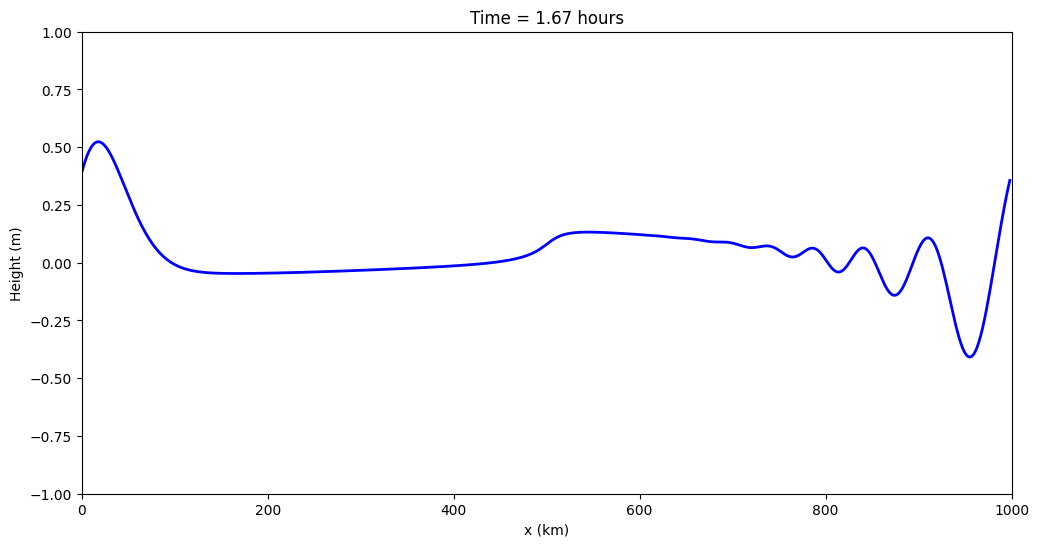

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

From the linear shallow water equations:
$$\frac{\partial u}{\partial t} = -g \frac{\partial h}{\partial x}$$
and using the anzatz $u=u_0 cos(k(x-ct))$ , $h=H_0 cos(k(x-ct))$

we can see that $c=\pm \sqrt{g H_0}$ which is a constant value away from the sea mount. Therefore, using $H_0=4km$, we expect the waves to propogate a  constant speed of 198 m/s.

In this we have used the assumptions that the background ocean waves $u$ are small compared to the wave speed $c$ allowing the non-linear terms to be neglected due to scaling: [ ]

assumptions, u small compared to c
h small compared to H
H min never 0
H const away from seamount

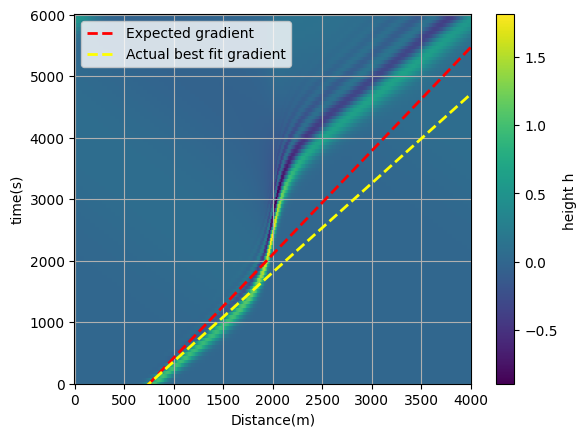

In [ ]:
# CREATE FIGURES HERE
#check number of points in x linspace
X=np.linspace(0, 4000, 512)
T=np.linspace(0, 6012, 101)
X, T= np.meshgrid(X, T)
plt.figure()
plt.pcolormesh(X, T, h_save)
#plt.pcolormesh(h_save)
plt.xlabel('Distance(m)')
plt.ylabel('time(s)')
line_x= np.linspace(0,4000,1000)
line_y= line_x * 1.684 -1263
line_z= line_x * 1.45 -1087.5
plt.plot(line_x, line_y, color='red', linewidth=2, linestyle='--', label='Expected gradient' )
plt.plot(line_x, line_z, color='yellow', linewidth=2, linestyle='--', label='Actual best fit gradient' )
plt.ylim(0,6012)
plt.colorbar(label='height h ')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(h_save.shape)

(101, 512)


we can see here that the expected gradient is not a bad fit although it is a little steep, reflecting the fact that the wave has already started to slow down at 750m. the expected gradient is a good fit for the model when the wave is far away from the sea mount whihc is located at 4km. however when it reaches the sea mount, the gradient quickly increases, reflecting a reduction in phasepeed of the maximum point of the wave, shown in yellow. this is due to the reduction in H. after the sea mount the gradinet returns to near its orginal valkue, showing how the peak of the wave acelerates back to pre sea mount behavour.

COMMENT ON RESULTS

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with total undisturbed fluid height

$$ H=H_0 - (H_0 - H_{min})e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 21s, Remaining: 0s, Rate: 4.8e-02/s


2025-11-21 10:16:57,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 21s, Remaining: 0s, Rate: 4.8e-02/s


INFO:__main__:Starting main loop


2025-11-21 10:16:57,536 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-21 10:17:06,613 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-21 10:17:06,615 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-21 10:17:06,617 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 21.09 sec


2025-11-21 10:17:06,618 solvers 0/1 INFO :: Setup time (init - iter 0): 21.09 sec


INFO:solvers:Warmup time (iter 0-10): 5.126 sec


2025-11-21 10:17:06,619 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.126 sec


INFO:solvers:Run time (iter 10-end): 3.951 sec


2025-11-21 10:17:06,621 solvers 0/1 INFO :: Run time (iter 10-end): 3.951 sec


INFO:solvers:CPU time (iter 10-end): 0.001098 cpu-hr


2025-11-21 10:17:06,623 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001098 cpu-hr


INFO:solvers:Speed: 3.013e+05 mode-stages/cpu-sec


2025-11-21 10:17:06,624 solvers 0/1 INFO :: Speed: 3.013e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 10:17:06,691 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9ofx6r3y/temp.m4v


2025-11-21 10:17:06,693 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9ofx6r3y/temp.m4v


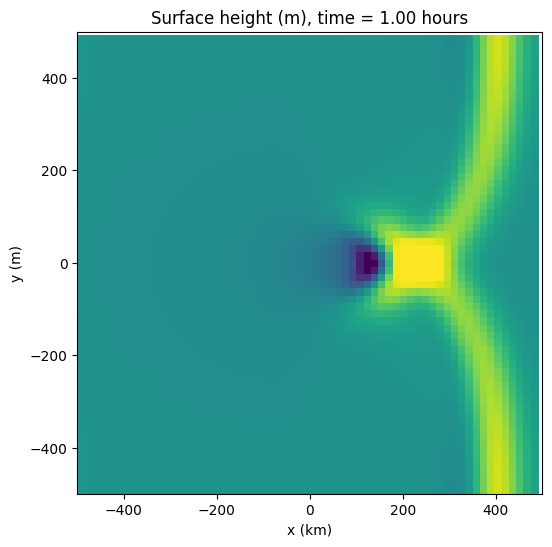

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.

STUDENT ANSWER HERE (~ 1 PARAGRAPH)
The wave propogates as a plane wave away from the sea mount. As it approaches the sea mount, the water height(h_0) decreases. since c is proportional to sqrt h0, the wave speed also reduces locally, creating a pertubation in the wave in the position of the sea mount. as the wave leaves the seamount, the water height increases again and the perturbed section of the wavefront accelerates, and begins to catch up to the rest of the front as seen in the video. Add more detail and mathematical rigor here.

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 25s, Remaining: 0s, Rate: 4.0e-02/s


2025-11-21 10:18:59,310 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 25s, Remaining: 0s, Rate: 4.0e-02/s


INFO:__main__:Starting main loop


2025-11-21 10:18:59,316 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-21 10:19:07,767 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-21 10:19:07,770 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-21 10:19:07,773 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 24.99 sec


2025-11-21 10:19:07,777 solvers 0/1 INFO :: Setup time (init - iter 0): 24.99 sec


INFO:solvers:Warmup time (iter 0-10): 4.023 sec


2025-11-21 10:19:07,780 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.023 sec


INFO:solvers:Run time (iter 10-end): 4.429 sec


2025-11-21 10:19:07,782 solvers 0/1 INFO :: Run time (iter 10-end): 4.429 sec


INFO:solvers:CPU time (iter 10-end): 0.00123 cpu-hr


2025-11-21 10:19:07,785 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00123 cpu-hr


INFO:solvers:Speed: 2.688e+05 mode-stages/cpu-sec


2025-11-21 10:19:07,789 solvers 0/1 INFO :: Speed: 2.688e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 10:19:07,846 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp97yrkuda/temp.m4v


2025-11-21 10:19:07,848 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp97yrkuda/temp.m4v


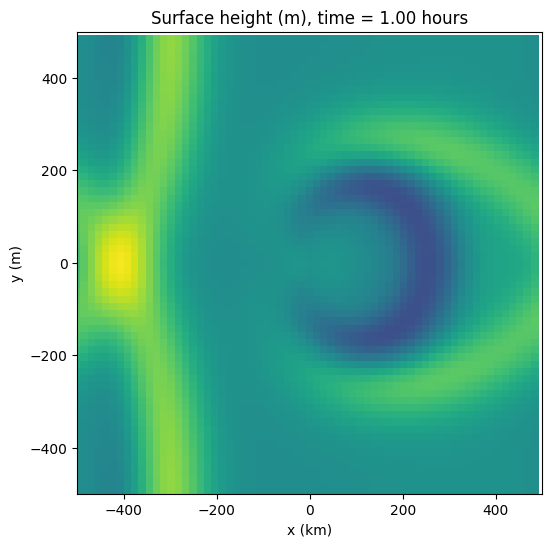

In [ ]:
# WAVE= 1.5 X HIGHER, 1.5 X WIDER
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 8 * kilometer # Reference ocean depth NEW
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 75 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 19s, Remaining: 0s, Rate: 5.2e-02/s


2025-11-21 10:20:54,156 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 19s, Remaining: 0s, Rate: 5.2e-02/s


INFO:__main__:Starting main loop


2025-11-21 10:20:54,163 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-21 10:21:05,781 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-21 10:21:05,786 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-21 10:21:05,787 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 19.17 sec


2025-11-21 10:21:05,789 solvers 0/1 INFO :: Setup time (init - iter 0): 19.17 sec


INFO:solvers:Warmup time (iter 0-10): 6.109 sec


2025-11-21 10:21:05,791 solvers 0/1 INFO :: Warmup time (iter 0-10): 6.109 sec


INFO:solvers:Run time (iter 10-end): 5.511 sec


2025-11-21 10:21:05,792 solvers 0/1 INFO :: Run time (iter 10-end): 5.511 sec


INFO:solvers:CPU time (iter 10-end): 0.001531 cpu-hr


2025-11-21 10:21:05,793 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001531 cpu-hr


INFO:solvers:Speed: 2.161e+05 mode-stages/cpu-sec


2025-11-21 10:21:05,794 solvers 0/1 INFO :: Speed: 2.161e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 10:21:05,913 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpxtxqmu5l/temp.m4v


2025-11-21 10:21:05,916 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpxtxqmu5l/temp.m4v


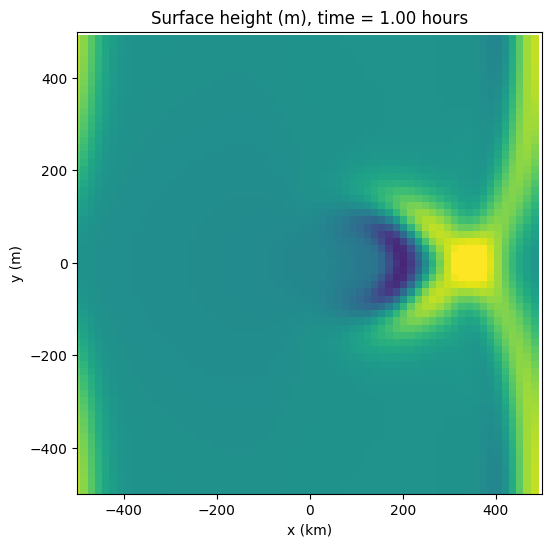

In [ ]:
#SEA MOUNT = higher (hmin= 1.25 original), H0 = 1.25 higher
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 5 * kilometer # Reference ocean depth NEW
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1.25 * kilometer # minimum depth above the seamount #NEW
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 26s, Remaining: 0s, Rate: 3.9e-02/s


2025-11-21 10:53:55,185 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 26s, Remaining: 0s, Rate: 3.9e-02/s


INFO:__main__:Starting main loop


2025-11-21 10:53:55,192 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-21 10:54:06,830 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-21 10:54:06,837 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-21 10:54:06,839 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 25.79 sec


2025-11-21 10:54:06,843 solvers 0/1 INFO :: Setup time (init - iter 0): 25.79 sec


INFO:solvers:Warmup time (iter 0-10): 6.926 sec


2025-11-21 10:54:06,846 solvers 0/1 INFO :: Warmup time (iter 0-10): 6.926 sec


INFO:solvers:Run time (iter 10-end): 4.717 sec


2025-11-21 10:54:06,849 solvers 0/1 INFO :: Run time (iter 10-end): 4.717 sec


INFO:solvers:CPU time (iter 10-end): 0.00131 cpu-hr


2025-11-21 10:54:06,852 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00131 cpu-hr


INFO:solvers:Speed: 2.524e+05 mode-stages/cpu-sec


2025-11-21 10:54:06,854 solvers 0/1 INFO :: Speed: 2.524e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 10:54:06,967 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprttp7n_g/temp.m4v


2025-11-21 10:54:06,970 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprttp7n_g/temp.m4v


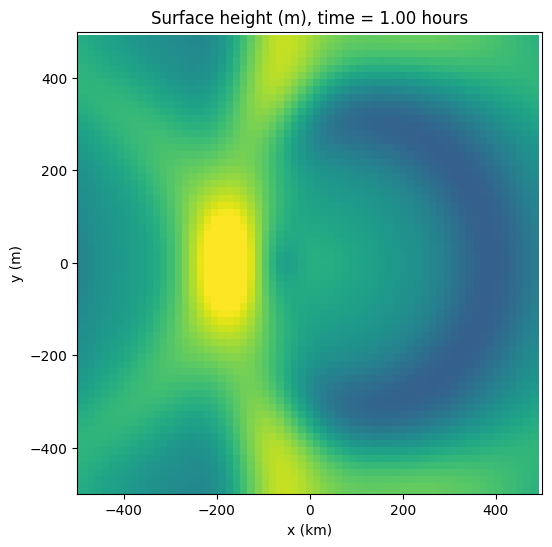

In [ ]:
# WAVE= 2.5 HIGHER, 1.5 X WIDER
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 12 * kilometer # Reference ocean depth NEW
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 100 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

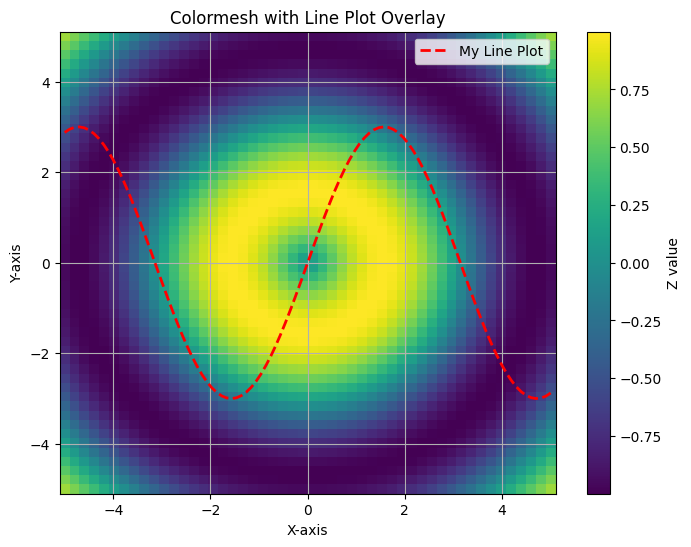

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X, Y, and h_save (for a specific time step) are available from the previous 2D simulation
# For demonstration, let's create some dummy data if they aren't readily available or if you want to test independently:

# Dummy data for pcolormesh (replace with your actual X, Y, h_save[n,:,:] if running after the animation)
# Example: Create a 2D grid and some Z data
N = 50
X_dummy, Y_dummy = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Z_dummy = np.sin(np.sqrt(X_dummy**2 + Y_dummy**2))

# Dummy data for the line plot
line_x = np.linspace(-5, 5, 100)
line_y = np.sin(line_x) * 3 # Some arbitrary function

plt.figure(figsize=(8, 6))

# Plot the pcolormesh
plt.pcolormesh(X_dummy, Y_dummy, Z_dummy, shading='auto', cmap='viridis')
plt.colorbar(label='Z value')

# Plot the line on top
plt.plot(line_x, line_y, color='red', linewidth=2, linestyle='--', label='My Line Plot')

plt.title('Colormesh with Line Plot Overlay')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

Expect to see that as we increase H0 (ie the wave gets larger) or decrease Hmin ie make the mount larger, the waves will at some point not obey the shallow water equations. this is because the height of the wave will become comaprarble to the height of the background ocean wave and ho will become comaprable to H0 ie we can no longer neglect the non linear terms.

this will look like the wave not holding its shape possibly even before the mount as it will be affected by the background ocean wave. as it passes over the mount it will no longer rebalacne the pertubation afterwards? because the perutbation will be too large and will create a growing instability?

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


2025-11-21 10:56:12,370 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.1e+01/s


2025-11-21 10:56:12,507 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.1e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


2025-11-21 10:56:12,645 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


2025-11-21 10:56:12,801 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.6e+01/s


2025-11-21 10:56:12,947 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 4.6e+01/s


2025-11-21 10:56:13,094 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2025-11-21 10:56:13,247 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2025-11-21 10:56:13,395 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2025-11-21 10:56:13,559 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2025-11-21 10:56:13,704 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:__main__:Starting main loop


2025-11-21 10:56:13,710 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-21 10:56:17,828 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-21 10:56:18,825 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-21 10:56:19,301 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-21 10:56:19,780 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-21 10:56:20,257 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-21 10:56:20,722 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-21 10:56:21,208 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-21 10:56:21,678 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-21 10:56:22,169 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-21 10:56:22,654 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-21 10:56:23,163 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-21 10:56:23,637 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-21 10:56:24,123 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-21 10:56:24,613 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-21 10:56:25,097 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-21 10:56:25,577 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-21 10:56:26,063 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-21 10:56:26,535 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-21 10:56:27,019 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-21 10:56:27,511 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-21 10:56:27,988 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-21 10:56:28,494 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-21 10:56:29,225 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-21 10:56:29,954 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-21 10:56:30,682 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-21 10:56:31,380 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-21 10:56:31,843 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-21 10:56:32,315 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-21 10:56:32,792 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-21 10:56:33,271 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-21 10:56:33,791 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-21 10:56:34,269 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-21 10:56:34,786 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-21 10:56:35,255 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-21 10:56:35,738 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-21 10:56:36,212 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-21 10:56:36,702 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-21 10:56:37,176 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-21 10:56:37,657 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-21 10:56:38,129 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-21 10:56:38,606 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-21 10:56:39,085 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-21 10:56:39,559 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-21 10:56:40,046 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-21 10:56:40,519 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-21 10:56:41,004 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-21 10:56:41,619 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-21 10:56:42,341 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-21 10:56:43,037 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-21 10:56:43,782 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-21 10:56:44,408 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-21 10:56:44,884 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-21 10:56:45,374 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-21 10:56:45,838 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-21 10:56:46,332 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-21 10:56:46,795 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-21 10:56:47,302 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-21 10:56:47,763 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-21 10:56:48,258 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-21 10:56:48,725 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-21 10:56:49,209 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-21 10:56:49,699 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-21 10:56:50,168 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-21 10:56:50,653 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-21 10:56:51,116 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-21 10:56:51,614 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-21 10:56:52,080 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-21 10:56:52,574 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-21 10:56:53,048 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-21 10:56:53,535 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-21 10:56:54,136 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-21 10:56:54,891 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-21 10:56:55,608 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-21 10:56:56,332 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-21 10:56:57,054 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-21 10:56:57,534 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-21 10:56:58,022 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-21 10:56:58,506 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-21 10:56:58,982 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-21 10:56:59,471 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-21 10:56:59,956 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-21 10:57:00,459 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-21 10:57:00,924 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-21 10:57:01,414 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-21 10:57:01,883 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-21 10:57:02,375 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-21 10:57:02,843 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-21 10:57:03,340 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-21 10:57:03,830 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-21 10:57:04,311 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-21 10:57:04,805 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-21 10:57:05,307 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-21 10:57:05,775 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-21 10:57:06,251 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-21 10:57:06,735 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-21 10:57:07,365 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-21 10:57:08,097 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-21 10:57:08,801 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-21 10:57:09,561 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-21 10:57:10,129 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-21 10:57:10,616 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-21 10:57:11,100 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-21 10:57:11,577 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-21 10:57:12,073 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-21 10:57:12,557 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-21 10:57:13,037 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-21 10:57:13,513 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-21 10:57:13,992 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-21 10:57:14,461 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-21 10:57:14,948 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-21 10:57:15,438 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-21 10:57:15,915 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-21 10:57:16,391 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-21 10:57:16,862 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-21 10:57:17,352 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-21 10:57:17,819 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-21 10:57:18,312 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-21 10:57:18,784 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-21 10:57:19,277 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-21 10:57:19,751 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-21 10:57:20,496 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-21 10:57:21,223 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-21 10:57:21,913 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-21 10:57:22,674 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-21 10:57:23,138 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-21 10:57:23,635 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-21 10:57:24,099 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-21 10:57:24,589 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-21 10:57:25,066 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-21 10:57:25,562 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-21 10:57:26,041 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-21 10:57:26,535 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-21 10:57:27,013 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-21 10:57:27,502 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-21 10:57:27,965 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-21 10:57:28,441 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-21 10:57:28,943 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-21 10:57:29,421 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-21 10:57:29,919 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-21 10:57:30,396 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-21 10:57:30,884 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-21 10:57:31,358 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-21 10:57:31,847 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-21 10:57:32,322 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-21 10:57:32,811 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-21 10:57:32,813 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-21 10:57:32,816 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.42 sec


2025-11-21 10:57:32,818 solvers 0/1 INFO :: Setup time (init - iter 0): 1.42 sec


INFO:solvers:Warmup time (iter 0-10): 5.067 sec


2025-11-21 10:57:32,819 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.067 sec


INFO:solvers:Run time (iter 10-end): 74.04 sec


2025-11-21 10:57:32,821 solvers 0/1 INFO :: Run time (iter 10-end): 74.04 sec


INFO:solvers:CPU time (iter 10-end): 0.02057 cpu-hr


2025-11-21 10:57:32,824 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02057 cpu-hr


INFO:solvers:Speed: 4.671e+05 mode-stages/cpu-sec


2025-11-21 10:57:32,830 solvers 0/1 INFO :: Speed: 4.671e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-21 11:01:37,984 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpyeye_fh0/temp.m4v


2025-11-21 11:01:37,987 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpyeye_fh0/temp.m4v


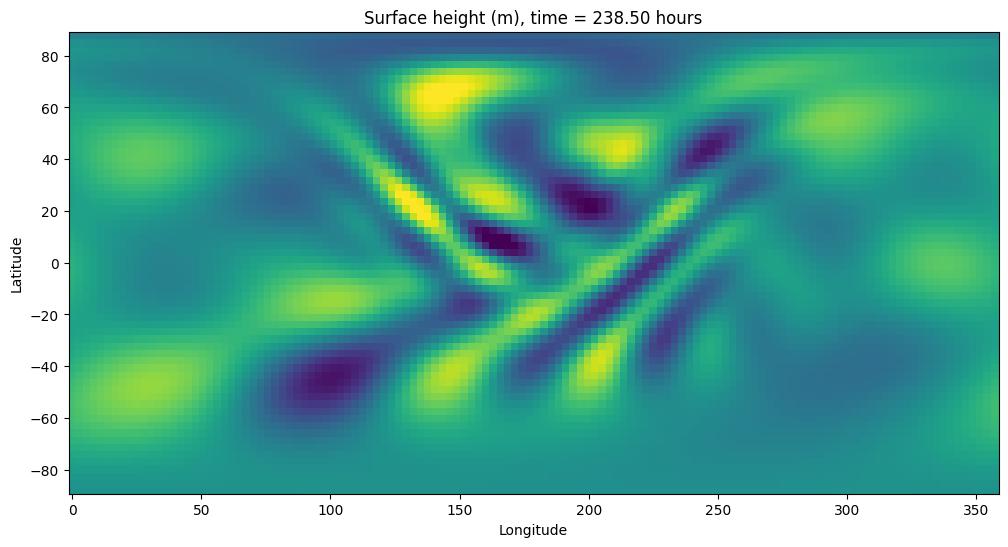

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

ADD PLOTS AND DISCUSSION HERE

In [ ]:
print(h_save.shape)
#[t, phi, theta]

(145, 128, 64)


INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.9e+01/s


2025-11-21 11:35:38,217 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


2025-11-21 11:35:38,347 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


2025-11-21 11:35:38,527 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


2025-11-21 11:35:38,650 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.1e+01/s


2025-11-21 11:35:38,744 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.1e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


2025-11-21 11:35:38,843 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.6e+01/s


2025-11-21 11:35:38,936 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.6e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


2025-11-21 11:35:39,033 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.0e+01/s


2025-11-21 11:35:39,128 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


2025-11-21 11:35:39,223 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


INFO:__main__:Starting main loop


2025-11-21 11:35:39,230 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.500000e+02, dt=1.500000e+02


2025-11-21 11:35:39,377 __main__ 0/1 INFO :: Iteration=1, Time=1.500000e+02, dt=1.500000e+02


INFO:__main__:Iteration=11, Time=1.650000e+03, dt=1.500000e+02


2025-11-21 11:35:39,859 __main__ 0/1 INFO :: Iteration=11, Time=1.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=21, Time=3.150000e+03, dt=1.500000e+02


2025-11-21 11:35:40,332 __main__ 0/1 INFO :: Iteration=21, Time=3.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=31, Time=4.650000e+03, dt=1.500000e+02


2025-11-21 11:35:41,075 __main__ 0/1 INFO :: Iteration=31, Time=4.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=41, Time=6.150000e+03, dt=1.500000e+02


2025-11-21 11:35:41,777 __main__ 0/1 INFO :: Iteration=41, Time=6.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=51, Time=7.650000e+03, dt=1.500000e+02


2025-11-21 11:35:42,488 __main__ 0/1 INFO :: Iteration=51, Time=7.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=61, Time=9.150000e+03, dt=1.500000e+02


2025-11-21 11:35:43,232 __main__ 0/1 INFO :: Iteration=61, Time=9.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=71, Time=1.065000e+04, dt=1.500000e+02


2025-11-21 11:35:43,697 __main__ 0/1 INFO :: Iteration=71, Time=1.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=81, Time=1.215000e+04, dt=1.500000e+02


2025-11-21 11:35:44,188 __main__ 0/1 INFO :: Iteration=81, Time=1.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=91, Time=1.365000e+04, dt=1.500000e+02


2025-11-21 11:35:44,655 __main__ 0/1 INFO :: Iteration=91, Time=1.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=101, Time=1.515000e+04, dt=1.500000e+02


2025-11-21 11:35:45,157 __main__ 0/1 INFO :: Iteration=101, Time=1.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=111, Time=1.665000e+04, dt=1.500000e+02


2025-11-21 11:35:45,641 __main__ 0/1 INFO :: Iteration=111, Time=1.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=121, Time=1.815000e+04, dt=1.500000e+02


2025-11-21 11:35:46,145 __main__ 0/1 INFO :: Iteration=121, Time=1.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=131, Time=1.965000e+04, dt=1.500000e+02


2025-11-21 11:35:46,622 __main__ 0/1 INFO :: Iteration=131, Time=1.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=141, Time=2.115000e+04, dt=1.500000e+02


2025-11-21 11:35:47,112 __main__ 0/1 INFO :: Iteration=141, Time=2.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=151, Time=2.265000e+04, dt=1.500000e+02


2025-11-21 11:35:47,582 __main__ 0/1 INFO :: Iteration=151, Time=2.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=161, Time=2.415000e+04, dt=1.500000e+02


2025-11-21 11:35:48,055 __main__ 0/1 INFO :: Iteration=161, Time=2.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=171, Time=2.565000e+04, dt=1.500000e+02


2025-11-21 11:35:48,553 __main__ 0/1 INFO :: Iteration=171, Time=2.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=181, Time=2.715000e+04, dt=1.500000e+02


2025-11-21 11:35:49,029 __main__ 0/1 INFO :: Iteration=181, Time=2.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=191, Time=2.865000e+04, dt=1.500000e+02


2025-11-21 11:35:49,513 __main__ 0/1 INFO :: Iteration=191, Time=2.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=201, Time=3.015000e+04, dt=1.500000e+02


2025-11-21 11:35:49,986 __main__ 0/1 INFO :: Iteration=201, Time=3.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=211, Time=3.165000e+04, dt=1.500000e+02


2025-11-21 11:35:50,463 __main__ 0/1 INFO :: Iteration=211, Time=3.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=221, Time=3.315000e+04, dt=1.500000e+02


2025-11-21 11:35:50,935 __main__ 0/1 INFO :: Iteration=221, Time=3.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=231, Time=3.465000e+04, dt=1.500000e+02


2025-11-21 11:35:51,428 __main__ 0/1 INFO :: Iteration=231, Time=3.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=241, Time=3.615000e+04, dt=1.500000e+02


2025-11-21 11:35:51,887 __main__ 0/1 INFO :: Iteration=241, Time=3.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=251, Time=3.765000e+04, dt=1.500000e+02


2025-11-21 11:35:52,369 __main__ 0/1 INFO :: Iteration=251, Time=3.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=261, Time=3.915000e+04, dt=1.500000e+02


2025-11-21 11:35:52,828 __main__ 0/1 INFO :: Iteration=261, Time=3.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=271, Time=4.065000e+04, dt=1.500000e+02


2025-11-21 11:35:53,373 __main__ 0/1 INFO :: Iteration=271, Time=4.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=281, Time=4.215000e+04, dt=1.500000e+02


2025-11-21 11:35:54,113 __main__ 0/1 INFO :: Iteration=281, Time=4.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=291, Time=4.365000e+04, dt=1.500000e+02


2025-11-21 11:35:54,835 __main__ 0/1 INFO :: Iteration=291, Time=4.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=301, Time=4.515000e+04, dt=1.500000e+02


2025-11-21 11:35:55,576 __main__ 0/1 INFO :: Iteration=301, Time=4.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=311, Time=4.665000e+04, dt=1.500000e+02


2025-11-21 11:35:56,252 __main__ 0/1 INFO :: Iteration=311, Time=4.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=321, Time=4.815000e+04, dt=1.500000e+02


2025-11-21 11:35:56,736 __main__ 0/1 INFO :: Iteration=321, Time=4.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=331, Time=4.965000e+04, dt=1.500000e+02


2025-11-21 11:35:57,212 __main__ 0/1 INFO :: Iteration=331, Time=4.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=341, Time=5.115000e+04, dt=1.500000e+02


2025-11-21 11:35:57,697 __main__ 0/1 INFO :: Iteration=341, Time=5.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=351, Time=5.265000e+04, dt=1.500000e+02


2025-11-21 11:35:58,186 __main__ 0/1 INFO :: Iteration=351, Time=5.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=361, Time=5.415000e+04, dt=1.500000e+02


2025-11-21 11:35:58,687 __main__ 0/1 INFO :: Iteration=361, Time=5.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=371, Time=5.565000e+04, dt=1.500000e+02


2025-11-21 11:35:59,156 __main__ 0/1 INFO :: Iteration=371, Time=5.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=381, Time=5.715000e+04, dt=1.500000e+02


2025-11-21 11:35:59,631 __main__ 0/1 INFO :: Iteration=381, Time=5.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=391, Time=5.865000e+04, dt=1.500000e+02


2025-11-21 11:36:00,116 __main__ 0/1 INFO :: Iteration=391, Time=5.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=401, Time=6.015000e+04, dt=1.500000e+02


2025-11-21 11:36:00,602 __main__ 0/1 INFO :: Iteration=401, Time=6.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=411, Time=6.165000e+04, dt=1.500000e+02


2025-11-21 11:36:01,097 __main__ 0/1 INFO :: Iteration=411, Time=6.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=421, Time=6.315000e+04, dt=1.500000e+02


2025-11-21 11:36:01,589 __main__ 0/1 INFO :: Iteration=421, Time=6.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=431, Time=6.465000e+04, dt=1.500000e+02


2025-11-21 11:36:02,071 __main__ 0/1 INFO :: Iteration=431, Time=6.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=441, Time=6.615000e+04, dt=1.500000e+02


2025-11-21 11:36:02,554 __main__ 0/1 INFO :: Iteration=441, Time=6.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=451, Time=6.765000e+04, dt=1.500000e+02


2025-11-21 11:36:03,043 __main__ 0/1 INFO :: Iteration=451, Time=6.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=461, Time=6.915000e+04, dt=1.500000e+02


2025-11-21 11:36:03,525 __main__ 0/1 INFO :: Iteration=461, Time=6.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=471, Time=7.065000e+04, dt=1.500000e+02


2025-11-21 11:36:04,007 __main__ 0/1 INFO :: Iteration=471, Time=7.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=481, Time=7.215000e+04, dt=1.500000e+02


2025-11-21 11:36:04,475 __main__ 0/1 INFO :: Iteration=481, Time=7.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=491, Time=7.365000e+04, dt=1.500000e+02


2025-11-21 11:36:04,960 __main__ 0/1 INFO :: Iteration=491, Time=7.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=501, Time=7.515000e+04, dt=1.500000e+02


2025-11-21 11:36:05,442 __main__ 0/1 INFO :: Iteration=501, Time=7.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=511, Time=7.665000e+04, dt=1.500000e+02


2025-11-21 11:36:05,900 __main__ 0/1 INFO :: Iteration=511, Time=7.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=521, Time=7.815000e+04, dt=1.500000e+02


2025-11-21 11:36:06,545 __main__ 0/1 INFO :: Iteration=521, Time=7.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=531, Time=7.965000e+04, dt=1.500000e+02


2025-11-21 11:36:07,271 __main__ 0/1 INFO :: Iteration=531, Time=7.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=541, Time=8.115000e+04, dt=1.500000e+02


2025-11-21 11:36:07,989 __main__ 0/1 INFO :: Iteration=541, Time=8.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=551, Time=8.265000e+04, dt=1.500000e+02


2025-11-21 11:36:08,745 __main__ 0/1 INFO :: Iteration=551, Time=8.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=561, Time=8.415000e+04, dt=1.500000e+02


2025-11-21 11:36:09,312 __main__ 0/1 INFO :: Iteration=561, Time=8.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=571, Time=8.565000e+04, dt=1.500000e+02


2025-11-21 11:36:09,790 __main__ 0/1 INFO :: Iteration=571, Time=8.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=581, Time=8.715000e+04, dt=1.500000e+02


2025-11-21 11:36:10,281 __main__ 0/1 INFO :: Iteration=581, Time=8.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=591, Time=8.865000e+04, dt=1.500000e+02


2025-11-21 11:36:10,749 __main__ 0/1 INFO :: Iteration=591, Time=8.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=601, Time=9.015000e+04, dt=1.500000e+02


2025-11-21 11:36:11,245 __main__ 0/1 INFO :: Iteration=601, Time=9.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=611, Time=9.165000e+04, dt=1.500000e+02


2025-11-21 11:36:11,740 __main__ 0/1 INFO :: Iteration=611, Time=9.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=621, Time=9.315000e+04, dt=1.500000e+02


2025-11-21 11:36:12,213 __main__ 0/1 INFO :: Iteration=621, Time=9.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=631, Time=9.465000e+04, dt=1.500000e+02


2025-11-21 11:36:12,707 __main__ 0/1 INFO :: Iteration=631, Time=9.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=641, Time=9.615000e+04, dt=1.500000e+02


2025-11-21 11:36:13,178 __main__ 0/1 INFO :: Iteration=641, Time=9.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=651, Time=9.765000e+04, dt=1.500000e+02


2025-11-21 11:36:13,667 __main__ 0/1 INFO :: Iteration=651, Time=9.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=661, Time=9.915000e+04, dt=1.500000e+02


2025-11-21 11:36:14,136 __main__ 0/1 INFO :: Iteration=661, Time=9.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=671, Time=1.006500e+05, dt=1.500000e+02


2025-11-21 11:36:14,622 __main__ 0/1 INFO :: Iteration=671, Time=1.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=681, Time=1.021500e+05, dt=1.500000e+02


2025-11-21 11:36:15,092 __main__ 0/1 INFO :: Iteration=681, Time=1.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=691, Time=1.036500e+05, dt=1.500000e+02


2025-11-21 11:36:15,580 __main__ 0/1 INFO :: Iteration=691, Time=1.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=701, Time=1.051500e+05, dt=1.500000e+02


2025-11-21 11:36:16,053 __main__ 0/1 INFO :: Iteration=701, Time=1.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=711, Time=1.066500e+05, dt=1.500000e+02


2025-11-21 11:36:16,544 __main__ 0/1 INFO :: Iteration=711, Time=1.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=721, Time=1.081500e+05, dt=1.500000e+02


2025-11-21 11:36:17,018 __main__ 0/1 INFO :: Iteration=721, Time=1.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=731, Time=1.096500e+05, dt=1.500000e+02


2025-11-21 11:36:17,494 __main__ 0/1 INFO :: Iteration=731, Time=1.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=741, Time=1.111500e+05, dt=1.500000e+02


2025-11-21 11:36:17,971 __main__ 0/1 INFO :: Iteration=741, Time=1.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=751, Time=1.126500e+05, dt=1.500000e+02


2025-11-21 11:36:18,447 __main__ 0/1 INFO :: Iteration=751, Time=1.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=761, Time=1.141500e+05, dt=1.500000e+02


2025-11-21 11:36:18,933 __main__ 0/1 INFO :: Iteration=761, Time=1.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=771, Time=1.156500e+05, dt=1.500000e+02


2025-11-21 11:36:19,672 __main__ 0/1 INFO :: Iteration=771, Time=1.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=781, Time=1.171500e+05, dt=1.500000e+02


2025-11-21 11:36:20,396 __main__ 0/1 INFO :: Iteration=781, Time=1.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=791, Time=1.186500e+05, dt=1.500000e+02


2025-11-21 11:36:21,125 __main__ 0/1 INFO :: Iteration=791, Time=1.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=801, Time=1.201500e+05, dt=1.500000e+02


2025-11-21 11:36:21,868 __main__ 0/1 INFO :: Iteration=801, Time=1.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=811, Time=1.216500e+05, dt=1.500000e+02


2025-11-21 11:36:22,338 __main__ 0/1 INFO :: Iteration=811, Time=1.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=821, Time=1.231500e+05, dt=1.500000e+02


2025-11-21 11:36:22,821 __main__ 0/1 INFO :: Iteration=821, Time=1.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=831, Time=1.246500e+05, dt=1.500000e+02


2025-11-21 11:36:23,312 __main__ 0/1 INFO :: Iteration=831, Time=1.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=841, Time=1.261500e+05, dt=1.500000e+02


2025-11-21 11:36:23,783 __main__ 0/1 INFO :: Iteration=841, Time=1.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=851, Time=1.276500e+05, dt=1.500000e+02


2025-11-21 11:36:24,276 __main__ 0/1 INFO :: Iteration=851, Time=1.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=861, Time=1.291500e+05, dt=1.500000e+02


2025-11-21 11:36:24,745 __main__ 0/1 INFO :: Iteration=861, Time=1.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=871, Time=1.306500e+05, dt=1.500000e+02


2025-11-21 11:36:25,239 __main__ 0/1 INFO :: Iteration=871, Time=1.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=881, Time=1.321500e+05, dt=1.500000e+02


2025-11-21 11:36:25,711 __main__ 0/1 INFO :: Iteration=881, Time=1.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=891, Time=1.336500e+05, dt=1.500000e+02


2025-11-21 11:36:26,212 __main__ 0/1 INFO :: Iteration=891, Time=1.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=901, Time=1.351500e+05, dt=1.500000e+02


2025-11-21 11:36:26,693 __main__ 0/1 INFO :: Iteration=901, Time=1.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=911, Time=1.366500e+05, dt=1.500000e+02


2025-11-21 11:36:27,202 __main__ 0/1 INFO :: Iteration=911, Time=1.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=921, Time=1.381500e+05, dt=1.500000e+02


2025-11-21 11:36:27,690 __main__ 0/1 INFO :: Iteration=921, Time=1.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=931, Time=1.396500e+05, dt=1.500000e+02


2025-11-21 11:36:28,187 __main__ 0/1 INFO :: Iteration=931, Time=1.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=941, Time=1.411500e+05, dt=1.500000e+02


2025-11-21 11:36:28,660 __main__ 0/1 INFO :: Iteration=941, Time=1.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=951, Time=1.426500e+05, dt=1.500000e+02


2025-11-21 11:36:29,160 __main__ 0/1 INFO :: Iteration=951, Time=1.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=961, Time=1.441500e+05, dt=1.500000e+02


2025-11-21 11:36:29,638 __main__ 0/1 INFO :: Iteration=961, Time=1.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=971, Time=1.456500e+05, dt=1.500000e+02


2025-11-21 11:36:30,130 __main__ 0/1 INFO :: Iteration=971, Time=1.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=981, Time=1.471500e+05, dt=1.500000e+02


2025-11-21 11:36:30,604 __main__ 0/1 INFO :: Iteration=981, Time=1.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=991, Time=1.486500e+05, dt=1.500000e+02


2025-11-21 11:36:31,070 __main__ 0/1 INFO :: Iteration=991, Time=1.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1001, Time=1.501500e+05, dt=1.500000e+02


2025-11-21 11:36:31,570 __main__ 0/1 INFO :: Iteration=1001, Time=1.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1011, Time=1.516500e+05, dt=1.500000e+02


2025-11-21 11:36:32,161 __main__ 0/1 INFO :: Iteration=1011, Time=1.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1021, Time=1.531500e+05, dt=1.500000e+02


2025-11-21 11:36:32,878 __main__ 0/1 INFO :: Iteration=1021, Time=1.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1031, Time=1.546500e+05, dt=1.500000e+02


2025-11-21 11:36:33,621 __main__ 0/1 INFO :: Iteration=1031, Time=1.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1041, Time=1.561500e+05, dt=1.500000e+02


2025-11-21 11:36:34,342 __main__ 0/1 INFO :: Iteration=1041, Time=1.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1051, Time=1.576500e+05, dt=1.500000e+02


2025-11-21 11:36:34,965 __main__ 0/1 INFO :: Iteration=1051, Time=1.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1061, Time=1.591500e+05, dt=1.500000e+02


2025-11-21 11:36:35,439 __main__ 0/1 INFO :: Iteration=1061, Time=1.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1071, Time=1.606500e+05, dt=1.500000e+02


2025-11-21 11:36:35,919 __main__ 0/1 INFO :: Iteration=1071, Time=1.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1081, Time=1.621500e+05, dt=1.500000e+02


2025-11-21 11:36:36,406 __main__ 0/1 INFO :: Iteration=1081, Time=1.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1091, Time=1.636500e+05, dt=1.500000e+02


2025-11-21 11:36:36,908 __main__ 0/1 INFO :: Iteration=1091, Time=1.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1101, Time=1.651500e+05, dt=1.500000e+02


2025-11-21 11:36:37,394 __main__ 0/1 INFO :: Iteration=1101, Time=1.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1111, Time=1.666500e+05, dt=1.500000e+02


2025-11-21 11:36:37,875 __main__ 0/1 INFO :: Iteration=1111, Time=1.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1121, Time=1.681500e+05, dt=1.500000e+02


2025-11-21 11:36:38,391 __main__ 0/1 INFO :: Iteration=1121, Time=1.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1131, Time=1.696500e+05, dt=1.500000e+02


2025-11-21 11:36:38,872 __main__ 0/1 INFO :: Iteration=1131, Time=1.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1141, Time=1.711500e+05, dt=1.500000e+02


2025-11-21 11:36:39,351 __main__ 0/1 INFO :: Iteration=1141, Time=1.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1151, Time=1.726500e+05, dt=1.500000e+02


2025-11-21 11:36:39,839 __main__ 0/1 INFO :: Iteration=1151, Time=1.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1161, Time=1.741500e+05, dt=1.500000e+02


2025-11-21 11:36:40,320 __main__ 0/1 INFO :: Iteration=1161, Time=1.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1171, Time=1.756500e+05, dt=1.500000e+02


2025-11-21 11:36:40,816 __main__ 0/1 INFO :: Iteration=1171, Time=1.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1181, Time=1.771500e+05, dt=1.500000e+02


2025-11-21 11:36:41,305 __main__ 0/1 INFO :: Iteration=1181, Time=1.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1191, Time=1.786500e+05, dt=1.500000e+02


2025-11-21 11:36:41,800 __main__ 0/1 INFO :: Iteration=1191, Time=1.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1201, Time=1.801500e+05, dt=1.500000e+02


2025-11-21 11:36:42,281 __main__ 0/1 INFO :: Iteration=1201, Time=1.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1211, Time=1.816500e+05, dt=1.500000e+02


2025-11-21 11:36:42,766 __main__ 0/1 INFO :: Iteration=1211, Time=1.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1221, Time=1.831500e+05, dt=1.500000e+02


2025-11-21 11:36:43,242 __main__ 0/1 INFO :: Iteration=1221, Time=1.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1231, Time=1.846500e+05, dt=1.500000e+02


2025-11-21 11:36:43,715 __main__ 0/1 INFO :: Iteration=1231, Time=1.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1241, Time=1.861500e+05, dt=1.500000e+02


2025-11-21 11:36:44,215 __main__ 0/1 INFO :: Iteration=1241, Time=1.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1251, Time=1.876500e+05, dt=1.500000e+02


2025-11-21 11:36:44,689 __main__ 0/1 INFO :: Iteration=1251, Time=1.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1261, Time=1.891500e+05, dt=1.500000e+02


2025-11-21 11:36:45,440 __main__ 0/1 INFO :: Iteration=1261, Time=1.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1271, Time=1.906500e+05, dt=1.500000e+02


2025-11-21 11:36:46,171 __main__ 0/1 INFO :: Iteration=1271, Time=1.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1281, Time=1.921500e+05, dt=1.500000e+02


2025-11-21 11:36:46,883 __main__ 0/1 INFO :: Iteration=1281, Time=1.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1291, Time=1.936500e+05, dt=1.500000e+02


2025-11-21 11:36:47,619 __main__ 0/1 INFO :: Iteration=1291, Time=1.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1301, Time=1.951500e+05, dt=1.500000e+02


2025-11-21 11:36:48,099 __main__ 0/1 INFO :: Iteration=1301, Time=1.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1311, Time=1.966500e+05, dt=1.500000e+02


2025-11-21 11:36:48,591 __main__ 0/1 INFO :: Iteration=1311, Time=1.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1321, Time=1.981500e+05, dt=1.500000e+02


2025-11-21 11:36:49,060 __main__ 0/1 INFO :: Iteration=1321, Time=1.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1331, Time=1.996500e+05, dt=1.500000e+02


2025-11-21 11:36:49,561 __main__ 0/1 INFO :: Iteration=1331, Time=1.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1341, Time=2.011500e+05, dt=1.500000e+02


2025-11-21 11:36:50,026 __main__ 0/1 INFO :: Iteration=1341, Time=2.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1351, Time=2.026500e+05, dt=1.500000e+02


2025-11-21 11:36:50,849 __main__ 0/1 INFO :: Iteration=1351, Time=2.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1361, Time=2.041500e+05, dt=1.500000e+02


2025-11-21 11:36:51,646 __main__ 0/1 INFO :: Iteration=1361, Time=2.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1371, Time=2.056500e+05, dt=1.500000e+02


2025-11-21 11:36:52,111 __main__ 0/1 INFO :: Iteration=1371, Time=2.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1381, Time=2.071500e+05, dt=1.500000e+02


2025-11-21 11:36:52,603 __main__ 0/1 INFO :: Iteration=1381, Time=2.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1391, Time=2.086500e+05, dt=1.500000e+02


2025-11-21 11:36:53,076 __main__ 0/1 INFO :: Iteration=1391, Time=2.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1401, Time=2.101500e+05, dt=1.500000e+02


2025-11-21 11:36:53,577 __main__ 0/1 INFO :: Iteration=1401, Time=2.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1411, Time=2.116500e+05, dt=1.500000e+02


2025-11-21 11:36:54,044 __main__ 0/1 INFO :: Iteration=1411, Time=2.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1421, Time=2.131500e+05, dt=1.500000e+02


2025-11-21 11:36:54,541 __main__ 0/1 INFO :: Iteration=1421, Time=2.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1431, Time=2.146500e+05, dt=1.500000e+02


2025-11-21 11:36:55,020 __main__ 0/1 INFO :: Iteration=1431, Time=2.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1441, Time=2.161500e+05, dt=1.500000e+02


2025-11-21 11:36:55,513 __main__ 0/1 INFO :: Iteration=1441, Time=2.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1451, Time=2.176500e+05, dt=1.500000e+02


2025-11-21 11:36:55,985 __main__ 0/1 INFO :: Iteration=1451, Time=2.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1461, Time=2.191500e+05, dt=1.500000e+02


2025-11-21 11:36:56,467 __main__ 0/1 INFO :: Iteration=1461, Time=2.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1471, Time=2.206500e+05, dt=1.500000e+02


2025-11-21 11:36:56,951 __main__ 0/1 INFO :: Iteration=1471, Time=2.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1481, Time=2.221500e+05, dt=1.500000e+02


2025-11-21 11:36:57,421 __main__ 0/1 INFO :: Iteration=1481, Time=2.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1491, Time=2.236500e+05, dt=1.500000e+02


2025-11-21 11:36:58,082 __main__ 0/1 INFO :: Iteration=1491, Time=2.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1501, Time=2.251500e+05, dt=1.500000e+02


2025-11-21 11:36:58,823 __main__ 0/1 INFO :: Iteration=1501, Time=2.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1511, Time=2.266500e+05, dt=1.500000e+02


2025-11-21 11:36:59,529 __main__ 0/1 INFO :: Iteration=1511, Time=2.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1521, Time=2.281500e+05, dt=1.500000e+02


2025-11-21 11:37:00,276 __main__ 0/1 INFO :: Iteration=1521, Time=2.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1531, Time=2.296500e+05, dt=1.500000e+02


2025-11-21 11:37:00,837 __main__ 0/1 INFO :: Iteration=1531, Time=2.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1541, Time=2.311500e+05, dt=1.500000e+02


2025-11-21 11:37:01,341 __main__ 0/1 INFO :: Iteration=1541, Time=2.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1551, Time=2.326500e+05, dt=1.500000e+02


2025-11-21 11:37:01,844 __main__ 0/1 INFO :: Iteration=1551, Time=2.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1561, Time=2.341500e+05, dt=1.500000e+02


2025-11-21 11:37:02,325 __main__ 0/1 INFO :: Iteration=1561, Time=2.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1571, Time=2.356500e+05, dt=1.500000e+02


2025-11-21 11:37:02,801 __main__ 0/1 INFO :: Iteration=1571, Time=2.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1581, Time=2.371500e+05, dt=1.500000e+02


2025-11-21 11:37:03,286 __main__ 0/1 INFO :: Iteration=1581, Time=2.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1591, Time=2.386500e+05, dt=1.500000e+02


2025-11-21 11:37:03,767 __main__ 0/1 INFO :: Iteration=1591, Time=2.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1601, Time=2.401500e+05, dt=1.500000e+02


2025-11-21 11:37:04,262 __main__ 0/1 INFO :: Iteration=1601, Time=2.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1611, Time=2.416500e+05, dt=1.500000e+02


2025-11-21 11:37:04,731 __main__ 0/1 INFO :: Iteration=1611, Time=2.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1621, Time=2.431500e+05, dt=1.500000e+02


2025-11-21 11:37:05,217 __main__ 0/1 INFO :: Iteration=1621, Time=2.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1631, Time=2.446500e+05, dt=1.500000e+02


2025-11-21 11:37:05,693 __main__ 0/1 INFO :: Iteration=1631, Time=2.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1641, Time=2.461500e+05, dt=1.500000e+02


2025-11-21 11:37:06,171 __main__ 0/1 INFO :: Iteration=1641, Time=2.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1651, Time=2.476500e+05, dt=1.500000e+02


2025-11-21 11:37:06,642 __main__ 0/1 INFO :: Iteration=1651, Time=2.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1661, Time=2.491500e+05, dt=1.500000e+02


2025-11-21 11:37:07,121 __main__ 0/1 INFO :: Iteration=1661, Time=2.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1671, Time=2.506500e+05, dt=1.500000e+02


2025-11-21 11:37:07,596 __main__ 0/1 INFO :: Iteration=1671, Time=2.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1681, Time=2.521500e+05, dt=1.500000e+02


2025-11-21 11:37:08,111 __main__ 0/1 INFO :: Iteration=1681, Time=2.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1691, Time=2.536500e+05, dt=1.500000e+02


2025-11-21 11:37:08,583 __main__ 0/1 INFO :: Iteration=1691, Time=2.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1701, Time=2.551500e+05, dt=1.500000e+02


2025-11-21 11:37:09,056 __main__ 0/1 INFO :: Iteration=1701, Time=2.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1711, Time=2.566500e+05, dt=1.500000e+02


2025-11-21 11:37:09,554 __main__ 0/1 INFO :: Iteration=1711, Time=2.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1721, Time=2.581500e+05, dt=1.500000e+02


2025-11-21 11:37:10,035 __main__ 0/1 INFO :: Iteration=1721, Time=2.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1731, Time=2.596500e+05, dt=1.500000e+02


2025-11-21 11:37:10,594 __main__ 0/1 INFO :: Iteration=1731, Time=2.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1741, Time=2.611500e+05, dt=1.500000e+02


2025-11-21 11:37:11,339 __main__ 0/1 INFO :: Iteration=1741, Time=2.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1751, Time=2.626500e+05, dt=1.500000e+02


2025-11-21 11:37:12,034 __main__ 0/1 INFO :: Iteration=1751, Time=2.626500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1761, Time=2.641500e+05, dt=1.500000e+02


2025-11-21 11:37:12,787 __main__ 0/1 INFO :: Iteration=1761, Time=2.641500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1771, Time=2.656500e+05, dt=1.500000e+02


2025-11-21 11:37:13,475 __main__ 0/1 INFO :: Iteration=1771, Time=2.656500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1781, Time=2.671500e+05, dt=1.500000e+02


2025-11-21 11:37:13,940 __main__ 0/1 INFO :: Iteration=1781, Time=2.671500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1791, Time=2.686500e+05, dt=1.500000e+02


2025-11-21 11:37:14,434 __main__ 0/1 INFO :: Iteration=1791, Time=2.686500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1801, Time=2.701500e+05, dt=1.500000e+02


2025-11-21 11:37:14,916 __main__ 0/1 INFO :: Iteration=1801, Time=2.701500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1811, Time=2.716500e+05, dt=1.500000e+02


2025-11-21 11:37:15,393 __main__ 0/1 INFO :: Iteration=1811, Time=2.716500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1821, Time=2.731500e+05, dt=1.500000e+02


2025-11-21 11:37:15,875 __main__ 0/1 INFO :: Iteration=1821, Time=2.731500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1831, Time=2.746500e+05, dt=1.500000e+02


2025-11-21 11:37:16,347 __main__ 0/1 INFO :: Iteration=1831, Time=2.746500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1841, Time=2.761500e+05, dt=1.500000e+02


2025-11-21 11:37:16,839 __main__ 0/1 INFO :: Iteration=1841, Time=2.761500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1851, Time=2.776500e+05, dt=1.500000e+02


2025-11-21 11:37:17,307 __main__ 0/1 INFO :: Iteration=1851, Time=2.776500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1861, Time=2.791500e+05, dt=1.500000e+02


2025-11-21 11:37:17,796 __main__ 0/1 INFO :: Iteration=1861, Time=2.791500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1871, Time=2.806500e+05, dt=1.500000e+02


2025-11-21 11:37:18,275 __main__ 0/1 INFO :: Iteration=1871, Time=2.806500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1881, Time=2.821500e+05, dt=1.500000e+02


2025-11-21 11:37:18,766 __main__ 0/1 INFO :: Iteration=1881, Time=2.821500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1891, Time=2.836500e+05, dt=1.500000e+02


2025-11-21 11:37:19,231 __main__ 0/1 INFO :: Iteration=1891, Time=2.836500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1901, Time=2.851500e+05, dt=1.500000e+02


2025-11-21 11:37:19,726 __main__ 0/1 INFO :: Iteration=1901, Time=2.851500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1911, Time=2.866500e+05, dt=1.500000e+02


2025-11-21 11:37:20,206 __main__ 0/1 INFO :: Iteration=1911, Time=2.866500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1921, Time=2.881500e+05, dt=1.500000e+02


2025-11-21 11:37:20,702 __main__ 0/1 INFO :: Iteration=1921, Time=2.881500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1931, Time=2.896500e+05, dt=1.500000e+02


2025-11-21 11:37:21,180 __main__ 0/1 INFO :: Iteration=1931, Time=2.896500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1941, Time=2.911500e+05, dt=1.500000e+02


2025-11-21 11:37:21,654 __main__ 0/1 INFO :: Iteration=1941, Time=2.911500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1951, Time=2.926500e+05, dt=1.500000e+02


2025-11-21 11:37:22,137 __main__ 0/1 INFO :: Iteration=1951, Time=2.926500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1961, Time=2.941500e+05, dt=1.500000e+02


2025-11-21 11:37:22,614 __main__ 0/1 INFO :: Iteration=1961, Time=2.941500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1971, Time=2.956500e+05, dt=1.500000e+02


2025-11-21 11:37:23,108 __main__ 0/1 INFO :: Iteration=1971, Time=2.956500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1981, Time=2.971500e+05, dt=1.500000e+02


2025-11-21 11:37:23,742 __main__ 0/1 INFO :: Iteration=1981, Time=2.971500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1991, Time=2.986500e+05, dt=1.500000e+02


2025-11-21 11:37:24,456 __main__ 0/1 INFO :: Iteration=1991, Time=2.986500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2001, Time=3.001500e+05, dt=1.500000e+02


2025-11-21 11:37:25,172 __main__ 0/1 INFO :: Iteration=2001, Time=3.001500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2011, Time=3.016500e+05, dt=1.500000e+02


2025-11-21 11:37:25,939 __main__ 0/1 INFO :: Iteration=2011, Time=3.016500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2021, Time=3.031500e+05, dt=1.500000e+02


2025-11-21 11:37:26,528 __main__ 0/1 INFO :: Iteration=2021, Time=3.031500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2031, Time=3.046500e+05, dt=1.500000e+02


2025-11-21 11:37:27,008 __main__ 0/1 INFO :: Iteration=2031, Time=3.046500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2041, Time=3.061500e+05, dt=1.500000e+02


2025-11-21 11:37:27,495 __main__ 0/1 INFO :: Iteration=2041, Time=3.061500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2051, Time=3.076500e+05, dt=1.500000e+02


2025-11-21 11:37:27,963 __main__ 0/1 INFO :: Iteration=2051, Time=3.076500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2061, Time=3.091500e+05, dt=1.500000e+02


2025-11-21 11:37:28,453 __main__ 0/1 INFO :: Iteration=2061, Time=3.091500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2071, Time=3.106500e+05, dt=1.500000e+02


2025-11-21 11:37:28,930 __main__ 0/1 INFO :: Iteration=2071, Time=3.106500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2081, Time=3.121500e+05, dt=1.500000e+02


2025-11-21 11:37:29,423 __main__ 0/1 INFO :: Iteration=2081, Time=3.121500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2091, Time=3.136500e+05, dt=1.500000e+02


2025-11-21 11:37:29,904 __main__ 0/1 INFO :: Iteration=2091, Time=3.136500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2101, Time=3.151500e+05, dt=1.500000e+02


2025-11-21 11:37:30,408 __main__ 0/1 INFO :: Iteration=2101, Time=3.151500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2111, Time=3.166500e+05, dt=1.500000e+02


2025-11-21 11:37:30,890 __main__ 0/1 INFO :: Iteration=2111, Time=3.166500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2121, Time=3.181500e+05, dt=1.500000e+02


2025-11-21 11:37:31,379 __main__ 0/1 INFO :: Iteration=2121, Time=3.181500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2131, Time=3.196500e+05, dt=1.500000e+02


2025-11-21 11:37:31,849 __main__ 0/1 INFO :: Iteration=2131, Time=3.196500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2141, Time=3.211500e+05, dt=1.500000e+02


2025-11-21 11:37:32,334 __main__ 0/1 INFO :: Iteration=2141, Time=3.211500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2151, Time=3.226500e+05, dt=1.500000e+02


2025-11-21 11:37:32,814 __main__ 0/1 INFO :: Iteration=2151, Time=3.226500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2161, Time=3.241500e+05, dt=1.500000e+02


2025-11-21 11:37:33,298 __main__ 0/1 INFO :: Iteration=2161, Time=3.241500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2171, Time=3.256500e+05, dt=1.500000e+02


2025-11-21 11:37:33,784 __main__ 0/1 INFO :: Iteration=2171, Time=3.256500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2181, Time=3.271500e+05, dt=1.500000e+02


2025-11-21 11:37:34,251 __main__ 0/1 INFO :: Iteration=2181, Time=3.271500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2191, Time=3.286500e+05, dt=1.500000e+02


2025-11-21 11:37:34,738 __main__ 0/1 INFO :: Iteration=2191, Time=3.286500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2201, Time=3.301500e+05, dt=1.500000e+02


2025-11-21 11:37:35,215 __main__ 0/1 INFO :: Iteration=2201, Time=3.301500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2211, Time=3.316500e+05, dt=1.500000e+02


2025-11-21 11:37:35,719 __main__ 0/1 INFO :: Iteration=2211, Time=3.316500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2221, Time=3.331500e+05, dt=1.500000e+02


2025-11-21 11:37:36,201 __main__ 0/1 INFO :: Iteration=2221, Time=3.331500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2231, Time=3.346500e+05, dt=1.500000e+02


2025-11-21 11:37:36,946 __main__ 0/1 INFO :: Iteration=2231, Time=3.346500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2241, Time=3.361500e+05, dt=1.500000e+02


2025-11-21 11:37:37,674 __main__ 0/1 INFO :: Iteration=2241, Time=3.361500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2251, Time=3.376500e+05, dt=1.500000e+02


2025-11-21 11:37:38,410 __main__ 0/1 INFO :: Iteration=2251, Time=3.376500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2261, Time=3.391500e+05, dt=1.500000e+02


2025-11-21 11:37:39,302 __main__ 0/1 INFO :: Iteration=2261, Time=3.391500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2271, Time=3.406500e+05, dt=1.500000e+02


2025-11-21 11:37:39,791 __main__ 0/1 INFO :: Iteration=2271, Time=3.406500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2281, Time=3.421500e+05, dt=1.500000e+02


2025-11-21 11:37:40,264 __main__ 0/1 INFO :: Iteration=2281, Time=3.421500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2291, Time=3.436500e+05, dt=1.500000e+02


2025-11-21 11:37:40,752 __main__ 0/1 INFO :: Iteration=2291, Time=3.436500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2301, Time=3.451500e+05, dt=1.500000e+02


2025-11-21 11:37:41,252 __main__ 0/1 INFO :: Iteration=2301, Time=3.451500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2311, Time=3.466500e+05, dt=1.500000e+02


2025-11-21 11:37:41,743 __main__ 0/1 INFO :: Iteration=2311, Time=3.466500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2321, Time=3.481500e+05, dt=1.500000e+02


2025-11-21 11:37:42,231 __main__ 0/1 INFO :: Iteration=2321, Time=3.481500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2331, Time=3.496500e+05, dt=1.500000e+02


2025-11-21 11:37:42,708 __main__ 0/1 INFO :: Iteration=2331, Time=3.496500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2341, Time=3.511500e+05, dt=1.500000e+02


2025-11-21 11:37:43,215 __main__ 0/1 INFO :: Iteration=2341, Time=3.511500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2351, Time=3.526500e+05, dt=1.500000e+02


2025-11-21 11:37:43,698 __main__ 0/1 INFO :: Iteration=2351, Time=3.526500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2361, Time=3.541500e+05, dt=1.500000e+02


2025-11-21 11:37:44,189 __main__ 0/1 INFO :: Iteration=2361, Time=3.541500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2371, Time=3.556500e+05, dt=1.500000e+02


2025-11-21 11:37:44,664 __main__ 0/1 INFO :: Iteration=2371, Time=3.556500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2381, Time=3.571500e+05, dt=1.500000e+02


2025-11-21 11:37:45,155 __main__ 0/1 INFO :: Iteration=2381, Time=3.571500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2391, Time=3.586500e+05, dt=1.500000e+02


2025-11-21 11:37:45,641 __main__ 0/1 INFO :: Iteration=2391, Time=3.586500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2401, Time=3.601500e+05, dt=1.500000e+02


2025-11-21 11:37:46,144 __main__ 0/1 INFO :: Iteration=2401, Time=3.601500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2411, Time=3.616500e+05, dt=1.500000e+02


2025-11-21 11:37:46,653 __main__ 0/1 INFO :: Iteration=2411, Time=3.616500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2421, Time=3.631500e+05, dt=1.500000e+02


2025-11-21 11:37:47,153 __main__ 0/1 INFO :: Iteration=2421, Time=3.631500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2431, Time=3.646500e+05, dt=1.500000e+02


2025-11-21 11:37:47,624 __main__ 0/1 INFO :: Iteration=2431, Time=3.646500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2441, Time=3.661500e+05, dt=1.500000e+02


2025-11-21 11:37:48,113 __main__ 0/1 INFO :: Iteration=2441, Time=3.661500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2451, Time=3.676500e+05, dt=1.500000e+02


2025-11-21 11:37:48,591 __main__ 0/1 INFO :: Iteration=2451, Time=3.676500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2461, Time=3.691500e+05, dt=1.500000e+02


2025-11-21 11:37:49,062 __main__ 0/1 INFO :: Iteration=2461, Time=3.691500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2471, Time=3.706500e+05, dt=1.500000e+02


2025-11-21 11:37:49,712 __main__ 0/1 INFO :: Iteration=2471, Time=3.706500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2481, Time=3.721500e+05, dt=1.500000e+02


2025-11-21 11:37:50,426 __main__ 0/1 INFO :: Iteration=2481, Time=3.721500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2491, Time=3.736500e+05, dt=1.500000e+02


2025-11-21 11:37:51,122 __main__ 0/1 INFO :: Iteration=2491, Time=3.736500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2501, Time=3.751500e+05, dt=1.500000e+02


2025-11-21 11:37:51,892 __main__ 0/1 INFO :: Iteration=2501, Time=3.751500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2511, Time=3.766500e+05, dt=1.500000e+02


2025-11-21 11:37:52,475 __main__ 0/1 INFO :: Iteration=2511, Time=3.766500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2521, Time=3.781500e+05, dt=1.500000e+02


2025-11-21 11:37:52,942 __main__ 0/1 INFO :: Iteration=2521, Time=3.781500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2531, Time=3.796500e+05, dt=1.500000e+02


2025-11-21 11:37:53,431 __main__ 0/1 INFO :: Iteration=2531, Time=3.796500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2541, Time=3.811500e+05, dt=1.500000e+02


2025-11-21 11:37:53,910 __main__ 0/1 INFO :: Iteration=2541, Time=3.811500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2551, Time=3.826500e+05, dt=1.500000e+02


2025-11-21 11:37:54,389 __main__ 0/1 INFO :: Iteration=2551, Time=3.826500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2561, Time=3.841500e+05, dt=1.500000e+02


2025-11-21 11:37:54,882 __main__ 0/1 INFO :: Iteration=2561, Time=3.841500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2571, Time=3.856500e+05, dt=1.500000e+02


2025-11-21 11:37:55,374 __main__ 0/1 INFO :: Iteration=2571, Time=3.856500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2581, Time=3.871500e+05, dt=1.500000e+02


2025-11-21 11:37:55,864 __main__ 0/1 INFO :: Iteration=2581, Time=3.871500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2591, Time=3.886500e+05, dt=1.500000e+02


2025-11-21 11:37:56,352 __main__ 0/1 INFO :: Iteration=2591, Time=3.886500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2601, Time=3.901500e+05, dt=1.500000e+02


2025-11-21 11:37:56,842 __main__ 0/1 INFO :: Iteration=2601, Time=3.901500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2611, Time=3.916500e+05, dt=1.500000e+02


2025-11-21 11:37:57,316 __main__ 0/1 INFO :: Iteration=2611, Time=3.916500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2621, Time=3.931500e+05, dt=1.500000e+02


2025-11-21 11:37:57,805 __main__ 0/1 INFO :: Iteration=2621, Time=3.931500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2631, Time=3.946500e+05, dt=1.500000e+02


2025-11-21 11:37:58,283 __main__ 0/1 INFO :: Iteration=2631, Time=3.946500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2641, Time=3.961500e+05, dt=1.500000e+02


2025-11-21 11:37:58,772 __main__ 0/1 INFO :: Iteration=2641, Time=3.961500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2651, Time=3.976500e+05, dt=1.500000e+02


2025-11-21 11:37:59,244 __main__ 0/1 INFO :: Iteration=2651, Time=3.976500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2661, Time=3.991500e+05, dt=1.500000e+02


2025-11-21 11:37:59,731 __main__ 0/1 INFO :: Iteration=2661, Time=3.991500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2671, Time=4.006500e+05, dt=1.500000e+02


2025-11-21 11:38:00,212 __main__ 0/1 INFO :: Iteration=2671, Time=4.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2681, Time=4.021500e+05, dt=1.500000e+02


2025-11-21 11:38:00,708 __main__ 0/1 INFO :: Iteration=2681, Time=4.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2691, Time=4.036500e+05, dt=1.500000e+02


2025-11-21 11:38:01,195 __main__ 0/1 INFO :: Iteration=2691, Time=4.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2701, Time=4.051500e+05, dt=1.500000e+02


2025-11-21 11:38:01,678 __main__ 0/1 INFO :: Iteration=2701, Time=4.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2711, Time=4.066500e+05, dt=1.500000e+02


2025-11-21 11:38:02,177 __main__ 0/1 INFO :: Iteration=2711, Time=4.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2721, Time=4.081500e+05, dt=1.500000e+02


2025-11-21 11:38:02,928 __main__ 0/1 INFO :: Iteration=2721, Time=4.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2731, Time=4.096500e+05, dt=1.500000e+02


2025-11-21 11:38:03,642 __main__ 0/1 INFO :: Iteration=2731, Time=4.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2741, Time=4.111500e+05, dt=1.500000e+02


2025-11-21 11:38:04,370 __main__ 0/1 INFO :: Iteration=2741, Time=4.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2751, Time=4.126500e+05, dt=1.500000e+02


2025-11-21 11:38:05,104 __main__ 0/1 INFO :: Iteration=2751, Time=4.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2761, Time=4.141500e+05, dt=1.500000e+02


2025-11-21 11:38:05,585 __main__ 0/1 INFO :: Iteration=2761, Time=4.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2771, Time=4.156500e+05, dt=1.500000e+02


2025-11-21 11:38:06,075 __main__ 0/1 INFO :: Iteration=2771, Time=4.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2781, Time=4.171500e+05, dt=1.500000e+02


2025-11-21 11:38:06,559 __main__ 0/1 INFO :: Iteration=2781, Time=4.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2791, Time=4.186500e+05, dt=1.500000e+02


2025-11-21 11:38:07,031 __main__ 0/1 INFO :: Iteration=2791, Time=4.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2801, Time=4.201500e+05, dt=1.500000e+02


2025-11-21 11:38:07,531 __main__ 0/1 INFO :: Iteration=2801, Time=4.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2811, Time=4.216500e+05, dt=1.500000e+02


2025-11-21 11:38:08,009 __main__ 0/1 INFO :: Iteration=2811, Time=4.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2821, Time=4.231500e+05, dt=1.500000e+02


2025-11-21 11:38:08,521 __main__ 0/1 INFO :: Iteration=2821, Time=4.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2831, Time=4.246500e+05, dt=1.500000e+02


2025-11-21 11:38:08,997 __main__ 0/1 INFO :: Iteration=2831, Time=4.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2841, Time=4.261500e+05, dt=1.500000e+02


2025-11-21 11:38:09,501 __main__ 0/1 INFO :: Iteration=2841, Time=4.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2851, Time=4.276500e+05, dt=1.500000e+02


2025-11-21 11:38:09,983 __main__ 0/1 INFO :: Iteration=2851, Time=4.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2861, Time=4.291500e+05, dt=1.500000e+02


2025-11-21 11:38:10,484 __main__ 0/1 INFO :: Iteration=2861, Time=4.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2871, Time=4.306500e+05, dt=1.500000e+02


2025-11-21 11:38:10,971 __main__ 0/1 INFO :: Iteration=2871, Time=4.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2881, Time=4.321500e+05, dt=1.500000e+02


2025-11-21 11:38:11,478 __main__ 0/1 INFO :: Iteration=2881, Time=4.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2891, Time=4.336500e+05, dt=1.500000e+02


2025-11-21 11:38:11,970 __main__ 0/1 INFO :: Iteration=2891, Time=4.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2901, Time=4.351500e+05, dt=1.500000e+02


2025-11-21 11:38:12,494 __main__ 0/1 INFO :: Iteration=2901, Time=4.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2911, Time=4.366500e+05, dt=1.500000e+02


2025-11-21 11:38:12,970 __main__ 0/1 INFO :: Iteration=2911, Time=4.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2921, Time=4.381500e+05, dt=1.500000e+02


2025-11-21 11:38:13,466 __main__ 0/1 INFO :: Iteration=2921, Time=4.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2931, Time=4.396500e+05, dt=1.500000e+02


2025-11-21 11:38:13,937 __main__ 0/1 INFO :: Iteration=2931, Time=4.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2941, Time=4.411500e+05, dt=1.500000e+02


2025-11-21 11:38:14,431 __main__ 0/1 INFO :: Iteration=2941, Time=4.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2951, Time=4.426500e+05, dt=1.500000e+02


2025-11-21 11:38:14,910 __main__ 0/1 INFO :: Iteration=2951, Time=4.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2961, Time=4.441500e+05, dt=1.500000e+02


2025-11-21 11:38:15,586 __main__ 0/1 INFO :: Iteration=2961, Time=4.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2971, Time=4.456500e+05, dt=1.500000e+02


2025-11-21 11:38:16,298 __main__ 0/1 INFO :: Iteration=2971, Time=4.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2981, Time=4.471500e+05, dt=1.500000e+02


2025-11-21 11:38:16,987 __main__ 0/1 INFO :: Iteration=2981, Time=4.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2991, Time=4.486500e+05, dt=1.500000e+02


2025-11-21 11:38:17,727 __main__ 0/1 INFO :: Iteration=2991, Time=4.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3001, Time=4.501500e+05, dt=1.500000e+02


2025-11-21 11:38:18,303 __main__ 0/1 INFO :: Iteration=3001, Time=4.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3011, Time=4.516500e+05, dt=1.500000e+02


2025-11-21 11:38:18,798 __main__ 0/1 INFO :: Iteration=3011, Time=4.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3021, Time=4.531500e+05, dt=1.500000e+02


2025-11-21 11:38:19,281 __main__ 0/1 INFO :: Iteration=3021, Time=4.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3031, Time=4.546500e+05, dt=1.500000e+02


2025-11-21 11:38:19,768 __main__ 0/1 INFO :: Iteration=3031, Time=4.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3041, Time=4.561500e+05, dt=1.500000e+02


2025-11-21 11:38:20,245 __main__ 0/1 INFO :: Iteration=3041, Time=4.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3051, Time=4.576500e+05, dt=1.500000e+02


2025-11-21 11:38:20,720 __main__ 0/1 INFO :: Iteration=3051, Time=4.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3061, Time=4.591500e+05, dt=1.500000e+02


2025-11-21 11:38:21,215 __main__ 0/1 INFO :: Iteration=3061, Time=4.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3071, Time=4.606500e+05, dt=1.500000e+02


2025-11-21 11:38:21,701 __main__ 0/1 INFO :: Iteration=3071, Time=4.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3081, Time=4.621500e+05, dt=1.500000e+02


2025-11-21 11:38:22,191 __main__ 0/1 INFO :: Iteration=3081, Time=4.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3091, Time=4.636500e+05, dt=1.500000e+02


2025-11-21 11:38:22,693 __main__ 0/1 INFO :: Iteration=3091, Time=4.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3101, Time=4.651500e+05, dt=1.500000e+02


2025-11-21 11:38:23,193 __main__ 0/1 INFO :: Iteration=3101, Time=4.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3111, Time=4.666500e+05, dt=1.500000e+02


2025-11-21 11:38:23,677 __main__ 0/1 INFO :: Iteration=3111, Time=4.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3121, Time=4.681500e+05, dt=1.500000e+02


2025-11-21 11:38:24,171 __main__ 0/1 INFO :: Iteration=3121, Time=4.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3131, Time=4.696500e+05, dt=1.500000e+02


2025-11-21 11:38:24,651 __main__ 0/1 INFO :: Iteration=3131, Time=4.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3141, Time=4.711500e+05, dt=1.500000e+02


2025-11-21 11:38:25,150 __main__ 0/1 INFO :: Iteration=3141, Time=4.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3151, Time=4.726500e+05, dt=1.500000e+02


2025-11-21 11:38:25,632 __main__ 0/1 INFO :: Iteration=3151, Time=4.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3161, Time=4.741500e+05, dt=1.500000e+02


2025-11-21 11:38:26,138 __main__ 0/1 INFO :: Iteration=3161, Time=4.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3171, Time=4.756500e+05, dt=1.500000e+02


2025-11-21 11:38:26,626 __main__ 0/1 INFO :: Iteration=3171, Time=4.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3181, Time=4.771500e+05, dt=1.500000e+02


2025-11-21 11:38:27,132 __main__ 0/1 INFO :: Iteration=3181, Time=4.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3191, Time=4.786500e+05, dt=1.500000e+02


2025-11-21 11:38:27,604 __main__ 0/1 INFO :: Iteration=3191, Time=4.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3201, Time=4.801500e+05, dt=1.500000e+02


2025-11-21 11:38:28,170 __main__ 0/1 INFO :: Iteration=3201, Time=4.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3211, Time=4.816500e+05, dt=1.500000e+02


2025-11-21 11:38:28,901 __main__ 0/1 INFO :: Iteration=3211, Time=4.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3221, Time=4.831500e+05, dt=1.500000e+02


2025-11-21 11:38:29,630 __main__ 0/1 INFO :: Iteration=3221, Time=4.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3231, Time=4.846500e+05, dt=1.500000e+02


2025-11-21 11:38:30,375 __main__ 0/1 INFO :: Iteration=3231, Time=4.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3241, Time=4.861500e+05, dt=1.500000e+02


2025-11-21 11:38:31,033 __main__ 0/1 INFO :: Iteration=3241, Time=4.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3251, Time=4.876500e+05, dt=1.500000e+02


2025-11-21 11:38:31,529 __main__ 0/1 INFO :: Iteration=3251, Time=4.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3261, Time=4.891500e+05, dt=1.500000e+02


2025-11-21 11:38:32,030 __main__ 0/1 INFO :: Iteration=3261, Time=4.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3271, Time=4.906500e+05, dt=1.500000e+02


2025-11-21 11:38:32,530 __main__ 0/1 INFO :: Iteration=3271, Time=4.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3281, Time=4.921500e+05, dt=1.500000e+02


2025-11-21 11:38:33,012 __main__ 0/1 INFO :: Iteration=3281, Time=4.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3291, Time=4.936500e+05, dt=1.500000e+02


2025-11-21 11:38:33,507 __main__ 0/1 INFO :: Iteration=3291, Time=4.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3301, Time=4.951500e+05, dt=1.500000e+02


2025-11-21 11:38:33,983 __main__ 0/1 INFO :: Iteration=3301, Time=4.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3311, Time=4.966500e+05, dt=1.500000e+02


2025-11-21 11:38:34,475 __main__ 0/1 INFO :: Iteration=3311, Time=4.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3321, Time=4.981500e+05, dt=1.500000e+02


2025-11-21 11:38:34,969 __main__ 0/1 INFO :: Iteration=3321, Time=4.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3331, Time=4.996500e+05, dt=1.500000e+02


2025-11-21 11:38:35,461 __main__ 0/1 INFO :: Iteration=3331, Time=4.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3341, Time=5.011500e+05, dt=1.500000e+02


2025-11-21 11:38:35,935 __main__ 0/1 INFO :: Iteration=3341, Time=5.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3351, Time=5.026500e+05, dt=1.500000e+02


2025-11-21 11:38:36,417 __main__ 0/1 INFO :: Iteration=3351, Time=5.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3361, Time=5.041500e+05, dt=1.500000e+02


2025-11-21 11:38:36,903 __main__ 0/1 INFO :: Iteration=3361, Time=5.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3371, Time=5.056500e+05, dt=1.500000e+02


2025-11-21 11:38:37,378 __main__ 0/1 INFO :: Iteration=3371, Time=5.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3381, Time=5.071500e+05, dt=1.500000e+02


2025-11-21 11:38:37,867 __main__ 0/1 INFO :: Iteration=3381, Time=5.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3391, Time=5.086500e+05, dt=1.500000e+02


2025-11-21 11:38:38,367 __main__ 0/1 INFO :: Iteration=3391, Time=5.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3401, Time=5.101500e+05, dt=1.500000e+02


2025-11-21 11:38:38,866 __main__ 0/1 INFO :: Iteration=3401, Time=5.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3411, Time=5.116500e+05, dt=1.500000e+02


2025-11-21 11:38:39,341 __main__ 0/1 INFO :: Iteration=3411, Time=5.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3421, Time=5.131500e+05, dt=1.500000e+02


2025-11-21 11:38:39,830 __main__ 0/1 INFO :: Iteration=3421, Time=5.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3431, Time=5.146500e+05, dt=1.500000e+02


2025-11-21 11:38:40,322 __main__ 0/1 INFO :: Iteration=3431, Time=5.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3441, Time=5.161500e+05, dt=1.500000e+02


2025-11-21 11:38:40,825 __main__ 0/1 INFO :: Iteration=3441, Time=5.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3451, Time=5.176500e+05, dt=1.500000e+02


2025-11-21 11:38:41,557 __main__ 0/1 INFO :: Iteration=3451, Time=5.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3461, Time=5.191500e+05, dt=1.500000e+02


2025-11-21 11:38:42,288 __main__ 0/1 INFO :: Iteration=3461, Time=5.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3471, Time=5.206500e+05, dt=1.500000e+02


2025-11-21 11:38:43,005 __main__ 0/1 INFO :: Iteration=3471, Time=5.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3481, Time=5.221500e+05, dt=1.500000e+02


2025-11-21 11:38:43,745 __main__ 0/1 INFO :: Iteration=3481, Time=5.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3491, Time=5.236500e+05, dt=1.500000e+02


2025-11-21 11:38:44,244 __main__ 0/1 INFO :: Iteration=3491, Time=5.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3501, Time=5.251500e+05, dt=1.500000e+02


2025-11-21 11:38:44,740 __main__ 0/1 INFO :: Iteration=3501, Time=5.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3511, Time=5.266500e+05, dt=1.500000e+02


2025-11-21 11:38:45,234 __main__ 0/1 INFO :: Iteration=3511, Time=5.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3521, Time=5.281500e+05, dt=1.500000e+02


2025-11-21 11:38:45,723 __main__ 0/1 INFO :: Iteration=3521, Time=5.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3531, Time=5.296500e+05, dt=1.500000e+02


2025-11-21 11:38:46,228 __main__ 0/1 INFO :: Iteration=3531, Time=5.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3541, Time=5.311500e+05, dt=1.500000e+02


2025-11-21 11:38:46,714 __main__ 0/1 INFO :: Iteration=3541, Time=5.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3551, Time=5.326500e+05, dt=1.500000e+02


2025-11-21 11:38:47,218 __main__ 0/1 INFO :: Iteration=3551, Time=5.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3561, Time=5.341500e+05, dt=1.500000e+02


2025-11-21 11:38:47,705 __main__ 0/1 INFO :: Iteration=3561, Time=5.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3571, Time=5.356500e+05, dt=1.500000e+02


2025-11-21 11:38:48,204 __main__ 0/1 INFO :: Iteration=3571, Time=5.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3581, Time=5.371500e+05, dt=1.500000e+02


2025-11-21 11:38:48,695 __main__ 0/1 INFO :: Iteration=3581, Time=5.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3591, Time=5.386500e+05, dt=1.500000e+02


2025-11-21 11:38:49,182 __main__ 0/1 INFO :: Iteration=3591, Time=5.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3601, Time=5.401500e+05, dt=1.500000e+02


2025-11-21 11:38:49,671 __main__ 0/1 INFO :: Iteration=3601, Time=5.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3611, Time=5.416500e+05, dt=1.500000e+02


2025-11-21 11:38:50,159 __main__ 0/1 INFO :: Iteration=3611, Time=5.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3621, Time=5.431500e+05, dt=1.500000e+02


2025-11-21 11:38:50,644 __main__ 0/1 INFO :: Iteration=3621, Time=5.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3631, Time=5.446500e+05, dt=1.500000e+02


2025-11-21 11:38:51,115 __main__ 0/1 INFO :: Iteration=3631, Time=5.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3641, Time=5.461500e+05, dt=1.500000e+02


2025-11-21 11:38:51,610 __main__ 0/1 INFO :: Iteration=3641, Time=5.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3651, Time=5.476500e+05, dt=1.500000e+02


2025-11-21 11:38:52,087 __main__ 0/1 INFO :: Iteration=3651, Time=5.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3661, Time=5.491500e+05, dt=1.500000e+02


2025-11-21 11:38:52,586 __main__ 0/1 INFO :: Iteration=3661, Time=5.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3671, Time=5.506500e+05, dt=1.500000e+02


2025-11-21 11:38:53,059 __main__ 0/1 INFO :: Iteration=3671, Time=5.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3681, Time=5.521500e+05, dt=1.500000e+02


2025-11-21 11:38:53,566 __main__ 0/1 INFO :: Iteration=3681, Time=5.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3691, Time=5.536500e+05, dt=1.500000e+02


2025-11-21 11:38:54,227 __main__ 0/1 INFO :: Iteration=3691, Time=5.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3701, Time=5.551500e+05, dt=1.500000e+02


2025-11-21 11:38:54,982 __main__ 0/1 INFO :: Iteration=3701, Time=5.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3711, Time=5.566500e+05, dt=1.500000e+02


2025-11-21 11:38:55,690 __main__ 0/1 INFO :: Iteration=3711, Time=5.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3721, Time=5.581500e+05, dt=1.500000e+02


2025-11-21 11:38:56,459 __main__ 0/1 INFO :: Iteration=3721, Time=5.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3731, Time=5.596500e+05, dt=1.500000e+02


2025-11-21 11:38:57,013 __main__ 0/1 INFO :: Iteration=3731, Time=5.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3741, Time=5.611500e+05, dt=1.500000e+02


2025-11-21 11:38:57,494 __main__ 0/1 INFO :: Iteration=3741, Time=5.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3751, Time=5.626500e+05, dt=1.500000e+02


2025-11-21 11:38:57,984 __main__ 0/1 INFO :: Iteration=3751, Time=5.626500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3761, Time=5.641500e+05, dt=1.500000e+02


2025-11-21 11:38:58,459 __main__ 0/1 INFO :: Iteration=3761, Time=5.641500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3771, Time=5.656500e+05, dt=1.500000e+02


2025-11-21 11:38:58,954 __main__ 0/1 INFO :: Iteration=3771, Time=5.656500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3781, Time=5.671500e+05, dt=1.500000e+02


2025-11-21 11:38:59,441 __main__ 0/1 INFO :: Iteration=3781, Time=5.671500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3791, Time=5.686500e+05, dt=1.500000e+02


2025-11-21 11:38:59,927 __main__ 0/1 INFO :: Iteration=3791, Time=5.686500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3801, Time=5.701500e+05, dt=1.500000e+02


2025-11-21 11:39:00,420 __main__ 0/1 INFO :: Iteration=3801, Time=5.701500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3811, Time=5.716500e+05, dt=1.500000e+02


2025-11-21 11:39:00,915 __main__ 0/1 INFO :: Iteration=3811, Time=5.716500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3821, Time=5.731500e+05, dt=1.500000e+02


2025-11-21 11:39:01,401 __main__ 0/1 INFO :: Iteration=3821, Time=5.731500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3831, Time=5.746500e+05, dt=1.500000e+02


2025-11-21 11:39:01,895 __main__ 0/1 INFO :: Iteration=3831, Time=5.746500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3841, Time=5.761500e+05, dt=1.500000e+02


2025-11-21 11:39:02,381 __main__ 0/1 INFO :: Iteration=3841, Time=5.761500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3851, Time=5.776500e+05, dt=1.500000e+02


2025-11-21 11:39:02,869 __main__ 0/1 INFO :: Iteration=3851, Time=5.776500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3861, Time=5.791500e+05, dt=1.500000e+02


2025-11-21 11:39:03,358 __main__ 0/1 INFO :: Iteration=3861, Time=5.791500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3871, Time=5.806500e+05, dt=1.500000e+02


2025-11-21 11:39:03,855 __main__ 0/1 INFO :: Iteration=3871, Time=5.806500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3881, Time=5.821500e+05, dt=1.500000e+02


2025-11-21 11:39:04,326 __main__ 0/1 INFO :: Iteration=3881, Time=5.821500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3891, Time=5.836500e+05, dt=1.500000e+02


2025-11-21 11:39:04,829 __main__ 0/1 INFO :: Iteration=3891, Time=5.836500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3901, Time=5.851500e+05, dt=1.500000e+02


2025-11-21 11:39:05,333 __main__ 0/1 INFO :: Iteration=3901, Time=5.851500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3911, Time=5.866500e+05, dt=1.500000e+02


2025-11-21 11:39:05,805 __main__ 0/1 INFO :: Iteration=3911, Time=5.866500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3921, Time=5.881500e+05, dt=1.500000e+02


2025-11-21 11:39:06,300 __main__ 0/1 INFO :: Iteration=3921, Time=5.881500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3931, Time=5.896500e+05, dt=1.500000e+02


2025-11-21 11:39:06,845 __main__ 0/1 INFO :: Iteration=3931, Time=5.896500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3941, Time=5.911500e+05, dt=1.500000e+02


2025-11-21 11:39:07,571 __main__ 0/1 INFO :: Iteration=3941, Time=5.911500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3951, Time=5.926500e+05, dt=1.500000e+02


2025-11-21 11:39:08,312 __main__ 0/1 INFO :: Iteration=3951, Time=5.926500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3961, Time=5.941500e+05, dt=1.500000e+02


2025-11-21 11:39:09,036 __main__ 0/1 INFO :: Iteration=3961, Time=5.941500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3971, Time=5.956500e+05, dt=1.500000e+02


2025-11-21 11:39:09,729 __main__ 0/1 INFO :: Iteration=3971, Time=5.956500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3981, Time=5.971500e+05, dt=1.500000e+02


2025-11-21 11:39:10,221 __main__ 0/1 INFO :: Iteration=3981, Time=5.971500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3991, Time=5.986500e+05, dt=1.500000e+02


2025-11-21 11:39:10,711 __main__ 0/1 INFO :: Iteration=3991, Time=5.986500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4001, Time=6.001500e+05, dt=1.500000e+02


2025-11-21 11:39:11,199 __main__ 0/1 INFO :: Iteration=4001, Time=6.001500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4011, Time=6.016500e+05, dt=1.500000e+02


2025-11-21 11:39:11,706 __main__ 0/1 INFO :: Iteration=4011, Time=6.016500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4021, Time=6.031500e+05, dt=1.500000e+02


2025-11-21 11:39:12,181 __main__ 0/1 INFO :: Iteration=4021, Time=6.031500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4031, Time=6.046500e+05, dt=1.500000e+02


2025-11-21 11:39:12,687 __main__ 0/1 INFO :: Iteration=4031, Time=6.046500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4041, Time=6.061500e+05, dt=1.500000e+02


2025-11-21 11:39:13,166 __main__ 0/1 INFO :: Iteration=4041, Time=6.061500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4051, Time=6.076500e+05, dt=1.500000e+02


2025-11-21 11:39:13,662 __main__ 0/1 INFO :: Iteration=4051, Time=6.076500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4061, Time=6.091500e+05, dt=1.500000e+02


2025-11-21 11:39:14,133 __main__ 0/1 INFO :: Iteration=4061, Time=6.091500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4071, Time=6.106500e+05, dt=1.500000e+02


2025-11-21 11:39:14,629 __main__ 0/1 INFO :: Iteration=4071, Time=6.106500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4081, Time=6.121500e+05, dt=1.500000e+02


2025-11-21 11:39:15,110 __main__ 0/1 INFO :: Iteration=4081, Time=6.121500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4091, Time=6.136500e+05, dt=1.500000e+02


2025-11-21 11:39:15,617 __main__ 0/1 INFO :: Iteration=4091, Time=6.136500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4101, Time=6.151500e+05, dt=1.500000e+02


2025-11-21 11:39:16,098 __main__ 0/1 INFO :: Iteration=4101, Time=6.151500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4111, Time=6.166500e+05, dt=1.500000e+02


2025-11-21 11:39:16,605 __main__ 0/1 INFO :: Iteration=4111, Time=6.166500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4121, Time=6.181500e+05, dt=1.500000e+02


2025-11-21 11:39:17,079 __main__ 0/1 INFO :: Iteration=4121, Time=6.181500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4131, Time=6.196500e+05, dt=1.500000e+02


2025-11-21 11:39:17,573 __main__ 0/1 INFO :: Iteration=4131, Time=6.196500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4141, Time=6.211500e+05, dt=1.500000e+02


2025-11-21 11:39:18,046 __main__ 0/1 INFO :: Iteration=4141, Time=6.211500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4151, Time=6.226500e+05, dt=1.500000e+02


2025-11-21 11:39:18,544 __main__ 0/1 INFO :: Iteration=4151, Time=6.226500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4161, Time=6.241500e+05, dt=1.500000e+02


2025-11-21 11:39:19,015 __main__ 0/1 INFO :: Iteration=4161, Time=6.241500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4171, Time=6.256500e+05, dt=1.500000e+02


2025-11-21 11:39:19,489 __main__ 0/1 INFO :: Iteration=4171, Time=6.256500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4181, Time=6.271500e+05, dt=1.500000e+02


2025-11-21 11:39:20,206 __main__ 0/1 INFO :: Iteration=4181, Time=6.271500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4191, Time=6.286500e+05, dt=1.500000e+02


2025-11-21 11:39:20,947 __main__ 0/1 INFO :: Iteration=4191, Time=6.286500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4201, Time=6.301500e+05, dt=1.500000e+02


2025-11-21 11:39:21,679 __main__ 0/1 INFO :: Iteration=4201, Time=6.301500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4211, Time=6.316500e+05, dt=1.500000e+02


2025-11-21 11:39:22,451 __main__ 0/1 INFO :: Iteration=4211, Time=6.316500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4221, Time=6.331500e+05, dt=1.500000e+02


2025-11-21 11:39:22,970 __main__ 0/1 INFO :: Iteration=4221, Time=6.331500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4231, Time=6.346500e+05, dt=1.500000e+02


2025-11-21 11:39:23,456 __main__ 0/1 INFO :: Iteration=4231, Time=6.346500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4241, Time=6.361500e+05, dt=1.500000e+02


2025-11-21 11:39:23,952 __main__ 0/1 INFO :: Iteration=4241, Time=6.361500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4251, Time=6.376500e+05, dt=1.500000e+02


2025-11-21 11:39:24,430 __main__ 0/1 INFO :: Iteration=4251, Time=6.376500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4261, Time=6.391500e+05, dt=1.500000e+02


2025-11-21 11:39:24,936 __main__ 0/1 INFO :: Iteration=4261, Time=6.391500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4271, Time=6.406500e+05, dt=1.500000e+02


2025-11-21 11:39:25,418 __main__ 0/1 INFO :: Iteration=4271, Time=6.406500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4281, Time=6.421500e+05, dt=1.500000e+02


2025-11-21 11:39:25,894 __main__ 0/1 INFO :: Iteration=4281, Time=6.421500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4291, Time=6.436500e+05, dt=1.500000e+02


2025-11-21 11:39:26,398 __main__ 0/1 INFO :: Iteration=4291, Time=6.436500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4301, Time=6.451500e+05, dt=1.500000e+02


2025-11-21 11:39:26,886 __main__ 0/1 INFO :: Iteration=4301, Time=6.451500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4311, Time=6.466500e+05, dt=1.500000e+02


2025-11-21 11:39:27,395 __main__ 0/1 INFO :: Iteration=4311, Time=6.466500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4321, Time=6.481500e+05, dt=1.500000e+02


2025-11-21 11:39:27,866 __main__ 0/1 INFO :: Iteration=4321, Time=6.481500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4331, Time=6.496500e+05, dt=1.500000e+02


2025-11-21 11:39:28,364 __main__ 0/1 INFO :: Iteration=4331, Time=6.496500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4341, Time=6.511500e+05, dt=1.500000e+02


2025-11-21 11:39:28,835 __main__ 0/1 INFO :: Iteration=4341, Time=6.511500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4351, Time=6.526500e+05, dt=1.500000e+02


2025-11-21 11:39:29,334 __main__ 0/1 INFO :: Iteration=4351, Time=6.526500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4361, Time=6.541500e+05, dt=1.500000e+02


2025-11-21 11:39:29,805 __main__ 0/1 INFO :: Iteration=4361, Time=6.541500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4371, Time=6.556500e+05, dt=1.500000e+02


2025-11-21 11:39:30,297 __main__ 0/1 INFO :: Iteration=4371, Time=6.556500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4381, Time=6.571500e+05, dt=1.500000e+02


2025-11-21 11:39:30,776 __main__ 0/1 INFO :: Iteration=4381, Time=6.571500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4391, Time=6.586500e+05, dt=1.500000e+02


2025-11-21 11:39:31,277 __main__ 0/1 INFO :: Iteration=4391, Time=6.586500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4401, Time=6.601500e+05, dt=1.500000e+02


2025-11-21 11:39:31,754 __main__ 0/1 INFO :: Iteration=4401, Time=6.601500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4411, Time=6.616500e+05, dt=1.500000e+02


2025-11-21 11:39:32,237 __main__ 0/1 INFO :: Iteration=4411, Time=6.616500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4421, Time=6.631500e+05, dt=1.500000e+02


2025-11-21 11:39:32,847 __main__ 0/1 INFO :: Iteration=4421, Time=6.631500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4431, Time=6.646500e+05, dt=1.500000e+02


2025-11-21 11:39:33,578 __main__ 0/1 INFO :: Iteration=4431, Time=6.646500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4441, Time=6.661500e+05, dt=1.500000e+02


2025-11-21 11:39:34,279 __main__ 0/1 INFO :: Iteration=4441, Time=6.661500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4451, Time=6.676500e+05, dt=1.500000e+02


2025-11-21 11:39:35,023 __main__ 0/1 INFO :: Iteration=4451, Time=6.676500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4461, Time=6.691500e+05, dt=1.500000e+02


2025-11-21 11:39:35,657 __main__ 0/1 INFO :: Iteration=4461, Time=6.691500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4471, Time=6.706500e+05, dt=1.500000e+02


2025-11-21 11:39:36,143 __main__ 0/1 INFO :: Iteration=4471, Time=6.706500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4481, Time=6.721500e+05, dt=1.500000e+02


2025-11-21 11:39:36,637 __main__ 0/1 INFO :: Iteration=4481, Time=6.721500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4491, Time=6.736500e+05, dt=1.500000e+02


2025-11-21 11:39:37,112 __main__ 0/1 INFO :: Iteration=4491, Time=6.736500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4501, Time=6.751500e+05, dt=1.500000e+02


2025-11-21 11:39:37,609 __main__ 0/1 INFO :: Iteration=4501, Time=6.751500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4511, Time=6.766500e+05, dt=1.500000e+02


2025-11-21 11:39:38,083 __main__ 0/1 INFO :: Iteration=4511, Time=6.766500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4521, Time=6.781500e+05, dt=1.500000e+02


2025-11-21 11:39:38,599 __main__ 0/1 INFO :: Iteration=4521, Time=6.781500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4531, Time=6.796500e+05, dt=1.500000e+02


2025-11-21 11:39:39,070 __main__ 0/1 INFO :: Iteration=4531, Time=6.796500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4541, Time=6.811500e+05, dt=1.500000e+02


2025-11-21 11:39:39,540 __main__ 0/1 INFO :: Iteration=4541, Time=6.811500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4551, Time=6.826500e+05, dt=1.500000e+02


2025-11-21 11:39:40,037 __main__ 0/1 INFO :: Iteration=4551, Time=6.826500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4561, Time=6.841500e+05, dt=1.500000e+02


2025-11-21 11:39:40,513 __main__ 0/1 INFO :: Iteration=4561, Time=6.841500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4571, Time=6.856500e+05, dt=1.500000e+02


2025-11-21 11:39:41,015 __main__ 0/1 INFO :: Iteration=4571, Time=6.856500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4581, Time=6.871500e+05, dt=1.500000e+02


2025-11-21 11:39:41,489 __main__ 0/1 INFO :: Iteration=4581, Time=6.871500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4591, Time=6.886500e+05, dt=1.500000e+02


2025-11-21 11:39:41,979 __main__ 0/1 INFO :: Iteration=4591, Time=6.886500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4601, Time=6.901500e+05, dt=1.500000e+02


2025-11-21 11:39:42,457 __main__ 0/1 INFO :: Iteration=4601, Time=6.901500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4611, Time=6.916500e+05, dt=1.500000e+02


2025-11-21 11:39:42,961 __main__ 0/1 INFO :: Iteration=4611, Time=6.916500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4621, Time=6.931500e+05, dt=1.500000e+02


2025-11-21 11:39:43,452 __main__ 0/1 INFO :: Iteration=4621, Time=6.931500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4631, Time=6.946500e+05, dt=1.500000e+02


2025-11-21 11:39:43,945 __main__ 0/1 INFO :: Iteration=4631, Time=6.946500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4641, Time=6.961500e+05, dt=1.500000e+02


2025-11-21 11:39:44,430 __main__ 0/1 INFO :: Iteration=4641, Time=6.961500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4651, Time=6.976500e+05, dt=1.500000e+02


2025-11-21 11:39:44,921 __main__ 0/1 INFO :: Iteration=4651, Time=6.976500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4661, Time=6.991500e+05, dt=1.500000e+02


2025-11-21 11:39:45,413 __main__ 0/1 INFO :: Iteration=4661, Time=6.991500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4671, Time=7.006500e+05, dt=1.500000e+02


2025-11-21 11:39:46,167 __main__ 0/1 INFO :: Iteration=4671, Time=7.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4681, Time=7.021500e+05, dt=1.500000e+02


2025-11-21 11:39:46,878 __main__ 0/1 INFO :: Iteration=4681, Time=7.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4691, Time=7.036500e+05, dt=1.500000e+02


2025-11-21 11:39:47,599 __main__ 0/1 INFO :: Iteration=4691, Time=7.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4701, Time=7.051500e+05, dt=1.500000e+02


2025-11-21 11:39:48,360 __main__ 0/1 INFO :: Iteration=4701, Time=7.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4711, Time=7.066500e+05, dt=1.500000e+02


2025-11-21 11:39:48,841 __main__ 0/1 INFO :: Iteration=4711, Time=7.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4721, Time=7.081500e+05, dt=1.500000e+02


2025-11-21 11:39:49,346 __main__ 0/1 INFO :: Iteration=4721, Time=7.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4731, Time=7.096500e+05, dt=1.500000e+02


2025-11-21 11:39:49,822 __main__ 0/1 INFO :: Iteration=4731, Time=7.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4741, Time=7.111500e+05, dt=1.500000e+02


2025-11-21 11:39:50,315 __main__ 0/1 INFO :: Iteration=4741, Time=7.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4751, Time=7.126500e+05, dt=1.500000e+02


2025-11-21 11:39:50,789 __main__ 0/1 INFO :: Iteration=4751, Time=7.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4761, Time=7.141500e+05, dt=1.500000e+02


2025-11-21 11:39:51,286 __main__ 0/1 INFO :: Iteration=4761, Time=7.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4771, Time=7.156500e+05, dt=1.500000e+02


2025-11-21 11:39:51,769 __main__ 0/1 INFO :: Iteration=4771, Time=7.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4781, Time=7.171500e+05, dt=1.500000e+02


2025-11-21 11:39:52,256 __main__ 0/1 INFO :: Iteration=4781, Time=7.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4791, Time=7.186500e+05, dt=1.500000e+02


2025-11-21 11:39:52,747 __main__ 0/1 INFO :: Iteration=4791, Time=7.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4801, Time=7.201500e+05, dt=1.500000e+02


2025-11-21 11:39:53,256 __main__ 0/1 INFO :: Iteration=4801, Time=7.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4811, Time=7.216500e+05, dt=1.500000e+02


2025-11-21 11:39:53,768 __main__ 0/1 INFO :: Iteration=4811, Time=7.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4821, Time=7.231500e+05, dt=1.500000e+02


2025-11-21 11:39:54,269 __main__ 0/1 INFO :: Iteration=4821, Time=7.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4831, Time=7.246500e+05, dt=1.500000e+02


2025-11-21 11:39:54,766 __main__ 0/1 INFO :: Iteration=4831, Time=7.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4841, Time=7.261500e+05, dt=1.500000e+02


2025-11-21 11:39:55,273 __main__ 0/1 INFO :: Iteration=4841, Time=7.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4851, Time=7.276500e+05, dt=1.500000e+02


2025-11-21 11:39:55,771 __main__ 0/1 INFO :: Iteration=4851, Time=7.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4861, Time=7.291500e+05, dt=1.500000e+02


2025-11-21 11:39:56,288 __main__ 0/1 INFO :: Iteration=4861, Time=7.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4871, Time=7.306500e+05, dt=1.500000e+02


2025-11-21 11:39:56,779 __main__ 0/1 INFO :: Iteration=4871, Time=7.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4881, Time=7.321500e+05, dt=1.500000e+02


2025-11-21 11:39:57,257 __main__ 0/1 INFO :: Iteration=4881, Time=7.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4891, Time=7.336500e+05, dt=1.500000e+02


2025-11-21 11:39:57,749 __main__ 0/1 INFO :: Iteration=4891, Time=7.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4901, Time=7.351500e+05, dt=1.500000e+02


2025-11-21 11:39:58,229 __main__ 0/1 INFO :: Iteration=4901, Time=7.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4911, Time=7.366500e+05, dt=1.500000e+02


2025-11-21 11:39:58,916 __main__ 0/1 INFO :: Iteration=4911, Time=7.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4921, Time=7.381500e+05, dt=1.500000e+02


2025-11-21 11:39:59,614 __main__ 0/1 INFO :: Iteration=4921, Time=7.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4931, Time=7.396500e+05, dt=1.500000e+02


2025-11-21 11:40:00,322 __main__ 0/1 INFO :: Iteration=4931, Time=7.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4941, Time=7.411500e+05, dt=1.500000e+02


2025-11-21 11:40:01,091 __main__ 0/1 INFO :: Iteration=4941, Time=7.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4951, Time=7.426500e+05, dt=1.500000e+02


2025-11-21 11:40:01,647 __main__ 0/1 INFO :: Iteration=4951, Time=7.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4961, Time=7.441500e+05, dt=1.500000e+02


2025-11-21 11:40:02,148 __main__ 0/1 INFO :: Iteration=4961, Time=7.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4971, Time=7.456500e+05, dt=1.500000e+02


2025-11-21 11:40:02,627 __main__ 0/1 INFO :: Iteration=4971, Time=7.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4981, Time=7.471500e+05, dt=1.500000e+02


2025-11-21 11:40:03,143 __main__ 0/1 INFO :: Iteration=4981, Time=7.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4991, Time=7.486500e+05, dt=1.500000e+02


2025-11-21 11:40:03,636 __main__ 0/1 INFO :: Iteration=4991, Time=7.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5001, Time=7.501500e+05, dt=1.500000e+02


2025-11-21 11:40:04,138 __main__ 0/1 INFO :: Iteration=5001, Time=7.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5011, Time=7.516500e+05, dt=1.500000e+02


2025-11-21 11:40:04,618 __main__ 0/1 INFO :: Iteration=5011, Time=7.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5021, Time=7.531500e+05, dt=1.500000e+02


2025-11-21 11:40:05,110 __main__ 0/1 INFO :: Iteration=5021, Time=7.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5031, Time=7.546500e+05, dt=1.500000e+02


2025-11-21 11:40:05,590 __main__ 0/1 INFO :: Iteration=5031, Time=7.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5041, Time=7.561500e+05, dt=1.500000e+02


2025-11-21 11:40:06,082 __main__ 0/1 INFO :: Iteration=5041, Time=7.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5051, Time=7.576500e+05, dt=1.500000e+02


2025-11-21 11:40:06,564 __main__ 0/1 INFO :: Iteration=5051, Time=7.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5061, Time=7.591500e+05, dt=1.500000e+02


2025-11-21 11:40:07,049 __main__ 0/1 INFO :: Iteration=5061, Time=7.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5071, Time=7.606500e+05, dt=1.500000e+02


2025-11-21 11:40:07,530 __main__ 0/1 INFO :: Iteration=5071, Time=7.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5081, Time=7.621500e+05, dt=1.500000e+02


2025-11-21 11:40:08,004 __main__ 0/1 INFO :: Iteration=5081, Time=7.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5091, Time=7.636500e+05, dt=1.500000e+02


2025-11-21 11:40:08,526 __main__ 0/1 INFO :: Iteration=5091, Time=7.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5101, Time=7.651500e+05, dt=1.500000e+02


2025-11-21 11:40:09,010 __main__ 0/1 INFO :: Iteration=5101, Time=7.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5111, Time=7.666500e+05, dt=1.500000e+02


2025-11-21 11:40:09,499 __main__ 0/1 INFO :: Iteration=5111, Time=7.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5121, Time=7.681500e+05, dt=1.500000e+02


2025-11-21 11:40:09,974 __main__ 0/1 INFO :: Iteration=5121, Time=7.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5131, Time=7.696500e+05, dt=1.500000e+02


2025-11-21 11:40:10,473 __main__ 0/1 INFO :: Iteration=5131, Time=7.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5141, Time=7.711500e+05, dt=1.500000e+02


2025-11-21 11:40:10,959 __main__ 0/1 INFO :: Iteration=5141, Time=7.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5151, Time=7.726500e+05, dt=1.500000e+02


2025-11-21 11:40:11,574 __main__ 0/1 INFO :: Iteration=5151, Time=7.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5161, Time=7.741500e+05, dt=1.500000e+02


2025-11-21 11:40:12,299 __main__ 0/1 INFO :: Iteration=5161, Time=7.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5171, Time=7.756500e+05, dt=1.500000e+02


2025-11-21 11:40:13,012 __main__ 0/1 INFO :: Iteration=5171, Time=7.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5181, Time=7.771500e+05, dt=1.500000e+02


2025-11-21 11:40:13,771 __main__ 0/1 INFO :: Iteration=5181, Time=7.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5191, Time=7.786500e+05, dt=1.500000e+02


2025-11-21 11:40:14,418 __main__ 0/1 INFO :: Iteration=5191, Time=7.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5201, Time=7.801500e+05, dt=1.500000e+02


2025-11-21 11:40:14,913 __main__ 0/1 INFO :: Iteration=5201, Time=7.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5211, Time=7.816500e+05, dt=1.500000e+02


2025-11-21 11:40:15,396 __main__ 0/1 INFO :: Iteration=5211, Time=7.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5221, Time=7.831500e+05, dt=1.500000e+02


2025-11-21 11:40:15,884 __main__ 0/1 INFO :: Iteration=5221, Time=7.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5231, Time=7.846500e+05, dt=1.500000e+02


2025-11-21 11:40:16,374 __main__ 0/1 INFO :: Iteration=5231, Time=7.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5241, Time=7.861500e+05, dt=1.500000e+02


2025-11-21 11:40:16,865 __main__ 0/1 INFO :: Iteration=5241, Time=7.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5251, Time=7.876500e+05, dt=1.500000e+02


2025-11-21 11:40:17,349 __main__ 0/1 INFO :: Iteration=5251, Time=7.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5261, Time=7.891500e+05, dt=1.500000e+02


2025-11-21 11:40:17,838 __main__ 0/1 INFO :: Iteration=5261, Time=7.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5271, Time=7.906500e+05, dt=1.500000e+02


2025-11-21 11:40:18,318 __main__ 0/1 INFO :: Iteration=5271, Time=7.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5281, Time=7.921500e+05, dt=1.500000e+02


2025-11-21 11:40:18,815 __main__ 0/1 INFO :: Iteration=5281, Time=7.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5291, Time=7.936500e+05, dt=1.500000e+02


2025-11-21 11:40:19,298 __main__ 0/1 INFO :: Iteration=5291, Time=7.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5301, Time=7.951500e+05, dt=1.500000e+02


2025-11-21 11:40:19,789 __main__ 0/1 INFO :: Iteration=5301, Time=7.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5311, Time=7.966500e+05, dt=1.500000e+02


2025-11-21 11:40:20,271 __main__ 0/1 INFO :: Iteration=5311, Time=7.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5321, Time=7.981500e+05, dt=1.500000e+02


2025-11-21 11:40:20,764 __main__ 0/1 INFO :: Iteration=5321, Time=7.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5331, Time=7.996500e+05, dt=1.500000e+02


2025-11-21 11:40:21,248 __main__ 0/1 INFO :: Iteration=5331, Time=7.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5341, Time=8.011500e+05, dt=1.500000e+02


2025-11-21 11:40:21,716 __main__ 0/1 INFO :: Iteration=5341, Time=8.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5351, Time=8.026500e+05, dt=1.500000e+02


2025-11-21 11:40:22,211 __main__ 0/1 INFO :: Iteration=5351, Time=8.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5361, Time=8.041500e+05, dt=1.500000e+02


2025-11-21 11:40:22,696 __main__ 0/1 INFO :: Iteration=5361, Time=8.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5371, Time=8.056500e+05, dt=1.500000e+02


2025-11-21 11:40:23,192 __main__ 0/1 INFO :: Iteration=5371, Time=8.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5381, Time=8.071500e+05, dt=1.500000e+02


2025-11-21 11:40:23,677 __main__ 0/1 INFO :: Iteration=5381, Time=8.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5391, Time=8.086500e+05, dt=1.500000e+02


2025-11-21 11:40:24,170 __main__ 0/1 INFO :: Iteration=5391, Time=8.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5401, Time=8.101500e+05, dt=1.500000e+02


2025-11-21 11:40:24,937 __main__ 0/1 INFO :: Iteration=5401, Time=8.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5411, Time=8.116500e+05, dt=1.500000e+02


2025-11-21 11:40:25,663 __main__ 0/1 INFO :: Iteration=5411, Time=8.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5421, Time=8.131500e+05, dt=1.500000e+02


2025-11-21 11:40:26,400 __main__ 0/1 INFO :: Iteration=5421, Time=8.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5431, Time=8.146500e+05, dt=1.500000e+02


2025-11-21 11:40:27,156 __main__ 0/1 INFO :: Iteration=5431, Time=8.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5441, Time=8.161500e+05, dt=1.500000e+02


2025-11-21 11:40:27,645 __main__ 0/1 INFO :: Iteration=5441, Time=8.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5451, Time=8.176500e+05, dt=1.500000e+02


2025-11-21 11:40:28,125 __main__ 0/1 INFO :: Iteration=5451, Time=8.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5461, Time=8.191500e+05, dt=1.500000e+02


2025-11-21 11:40:28,625 __main__ 0/1 INFO :: Iteration=5461, Time=8.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5471, Time=8.206500e+05, dt=1.500000e+02


2025-11-21 11:40:29,105 __main__ 0/1 INFO :: Iteration=5471, Time=8.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5481, Time=8.221500e+05, dt=1.500000e+02


2025-11-21 11:40:29,604 __main__ 0/1 INFO :: Iteration=5481, Time=8.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5491, Time=8.236500e+05, dt=1.500000e+02


2025-11-21 11:40:30,082 __main__ 0/1 INFO :: Iteration=5491, Time=8.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5501, Time=8.251500e+05, dt=1.500000e+02


2025-11-21 11:40:30,596 __main__ 0/1 INFO :: Iteration=5501, Time=8.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5511, Time=8.266500e+05, dt=1.500000e+02


2025-11-21 11:40:31,078 __main__ 0/1 INFO :: Iteration=5511, Time=8.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5521, Time=8.281500e+05, dt=1.500000e+02


2025-11-21 11:40:31,577 __main__ 0/1 INFO :: Iteration=5521, Time=8.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5531, Time=8.296500e+05, dt=1.500000e+02


2025-11-21 11:40:32,050 __main__ 0/1 INFO :: Iteration=5531, Time=8.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5541, Time=8.311500e+05, dt=1.500000e+02


2025-11-21 11:40:32,546 __main__ 0/1 INFO :: Iteration=5541, Time=8.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5551, Time=8.326500e+05, dt=1.500000e+02


2025-11-21 11:40:33,033 __main__ 0/1 INFO :: Iteration=5551, Time=8.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5561, Time=8.341500e+05, dt=1.500000e+02


2025-11-21 11:40:33,548 __main__ 0/1 INFO :: Iteration=5561, Time=8.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5571, Time=8.356500e+05, dt=1.500000e+02


2025-11-21 11:40:34,032 __main__ 0/1 INFO :: Iteration=5571, Time=8.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5581, Time=8.371500e+05, dt=1.500000e+02


2025-11-21 11:40:34,529 __main__ 0/1 INFO :: Iteration=5581, Time=8.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5591, Time=8.386500e+05, dt=1.500000e+02


2025-11-21 11:40:35,005 __main__ 0/1 INFO :: Iteration=5591, Time=8.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5601, Time=8.401500e+05, dt=1.500000e+02


2025-11-21 11:40:35,507 __main__ 0/1 INFO :: Iteration=5601, Time=8.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5611, Time=8.416500e+05, dt=1.500000e+02


2025-11-21 11:40:35,979 __main__ 0/1 INFO :: Iteration=5611, Time=8.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5621, Time=8.431500e+05, dt=1.500000e+02


2025-11-21 11:40:36,462 __main__ 0/1 INFO :: Iteration=5621, Time=8.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5631, Time=8.446500e+05, dt=1.500000e+02


2025-11-21 11:40:36,956 __main__ 0/1 INFO :: Iteration=5631, Time=8.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5641, Time=8.461500e+05, dt=1.500000e+02


2025-11-21 11:40:37,649 __main__ 0/1 INFO :: Iteration=5641, Time=8.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5651, Time=8.476500e+05, dt=1.500000e+02


2025-11-21 11:40:38,365 __main__ 0/1 INFO :: Iteration=5651, Time=8.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5661, Time=8.491500e+05, dt=1.500000e+02


2025-11-21 11:40:39,067 __main__ 0/1 INFO :: Iteration=5661, Time=8.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5671, Time=8.506500e+05, dt=1.500000e+02


2025-11-21 11:40:39,826 __main__ 0/1 INFO :: Iteration=5671, Time=8.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5681, Time=8.521500e+05, dt=1.500000e+02


2025-11-21 11:40:40,407 __main__ 0/1 INFO :: Iteration=5681, Time=8.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5691, Time=8.536500e+05, dt=1.500000e+02


2025-11-21 11:40:40,883 __main__ 0/1 INFO :: Iteration=5691, Time=8.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5701, Time=8.551500e+05, dt=1.500000e+02


2025-11-21 11:40:41,397 __main__ 0/1 INFO :: Iteration=5701, Time=8.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5711, Time=8.566500e+05, dt=1.500000e+02


2025-11-21 11:40:41,868 __main__ 0/1 INFO :: Iteration=5711, Time=8.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5721, Time=8.581500e+05, dt=1.500000e+02


2025-11-21 11:40:42,363 __main__ 0/1 INFO :: Iteration=5721, Time=8.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5731, Time=8.596500e+05, dt=1.500000e+02


2025-11-21 11:40:42,831 __main__ 0/1 INFO :: Iteration=5731, Time=8.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5741, Time=8.611500e+05, dt=1.500000e+02


2025-11-21 11:40:43,331 __main__ 0/1 INFO :: Iteration=5741, Time=8.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5751, Time=8.626500e+05, dt=1.500000e+02


2025-11-21 11:40:43,819 __main__ 0/1 INFO :: Iteration=5751, Time=8.626500e+05, dt=1.500000e+02


INFO:solvers:Simulation stop time reached.


2025-11-21 11:40:44,279 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 5760


2025-11-21 11:40:44,280 solvers 0/1 INFO :: Final iteration: 5760


INFO:solvers:Final sim time: 864000.0


2025-11-21 11:40:44,282 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.061 sec


2025-11-21 11:40:44,286 solvers 0/1 INFO :: Setup time (init - iter 0): 1.061 sec


INFO:solvers:Warmup time (iter 0-10): 0.5813 sec


2025-11-21 11:40:44,288 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.5813 sec


INFO:solvers:Run time (iter 10-end): 304.5 sec


2025-11-21 11:40:44,291 solvers 0/1 INFO :: Run time (iter 10-end): 304.5 sec


INFO:solvers:CPU time (iter 10-end): 0.08457 cpu-hr


2025-11-21 11:40:44,293 solvers 0/1 INFO :: CPU time (iter 10-end): 0.08457 cpu-hr


INFO:solvers:Speed: 4.567e+05 mode-stages/cpu-sec


2025-11-21 11:40:44,295 solvers 0/1 INFO :: Speed: 4.567e+05 mode-stages/cpu-sec


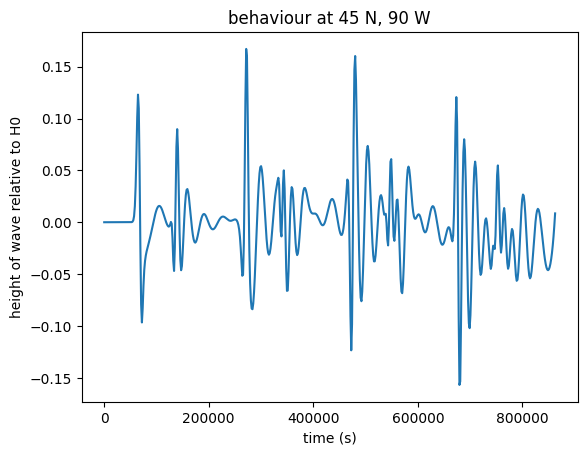

In [ ]:
timestep=150 * second

phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

plt.plot(t_save, h_save[:, 96, 16])
plt.title('behaviour at 45 N, 90 W, timesampling every 2.5 mins')
plt.ylabel('height of wave relative to H0')
plt.xlabel('time (s)')
plt.show()

why does the behaviour change?

suspected interference from reflecting waves, constructuve interference produces a larger wave.we see more marked peaks and troughs from 400,000 s showing presence of stationary waves. reduce the timestep to save h more regularly

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the longitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [4]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)

#DAMPING TERM
tau= 0.1* day
#def f_phi(phi):
  #if phi > np.pi/2:
    #return 0.5*(1+np.tanh((phi-1.5*np.pi)/0.1*np.pi))+0.5*(1-np.tanh((phi-0.5*np.pi)/0.1*np.pi))
  #elif phi< -np.pi/2:
    #return 0.5*(1+np.tanh((phi-1.5*np.pi)/0.1*np.pi))+0.5*(1-np.tanh((phi-0.5*np.pi)/0.1*np.pi))
  #else:
    #return 0
#damping= -(1/tau)* f_phi(phi)*h['g']
damping_factor = dist.Field(name='damping_factor', bases = basis)
damping_factor.change_scales(1)
damping_factor['g']= 0.5*(1+np.tanh((phi-1.5*np.pi)/0.1*np.pi))+0.5*(1-np.tanh((phi-0.5*np.pi)/0.1*np.pi))

h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) -(1/tau) *damping_factor *h") #NEW DAMPING TERM

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


2025-11-23 20:14:23,907 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.0e+01/s


2025-11-23 20:14:24,018 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


2025-11-23 20:14:24,177 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.8e+01/s


2025-11-23 20:14:24,314 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.8e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.9e+01/s


2025-11-23 20:14:24,445 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.0e+01/s


2025-11-23 20:14:24,583 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


2025-11-23 20:14:24,719 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


2025-11-23 20:14:24,862 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


2025-11-23 20:14:25,000 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


2025-11-23 20:14:25,152 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


INFO:__main__:Starting main loop


2025-11-23 20:14:25,159 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-23 20:14:29,556 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-23 20:14:30,470 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-23 20:14:31,084 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-23 20:14:31,821 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-23 20:14:32,408 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-23 20:14:33,036 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-23 20:14:33,697 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-23 20:14:34,369 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-23 20:14:35,157 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-23 20:14:35,918 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-23 20:14:36,824 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-23 20:14:37,471 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-23 20:14:37,941 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-23 20:14:38,676 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-23 20:14:39,541 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-23 20:14:40,354 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-23 20:14:41,105 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-23 20:14:41,683 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-23 20:14:42,248 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-23 20:14:42,894 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-23 20:14:43,518 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-23 20:14:44,116 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-23 20:14:44,709 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-23 20:14:45,292 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-23 20:14:45,791 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-23 20:14:46,768 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-23 20:14:47,254 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-23 20:14:47,746 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-23 20:14:48,260 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-23 20:14:48,787 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-23 20:14:49,283 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-23 20:14:49,757 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-23 20:14:50,267 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-23 20:14:50,856 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-23 20:14:51,584 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-23 20:14:52,329 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-23 20:14:53,075 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-23 20:14:53,806 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-23 20:14:54,322 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-23 20:14:54,816 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-23 20:14:55,339 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-23 20:14:55,829 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-23 20:14:56,345 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-23 20:14:56,837 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-23 20:14:57,355 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-23 20:14:57,902 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-23 20:14:58,515 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-23 20:14:59,019 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-23 20:14:59,535 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-23 20:15:00,018 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-23 20:15:00,550 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-23 20:15:01,150 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-23 20:15:01,722 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-23 20:15:02,217 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-23 20:15:02,737 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-23 20:15:03,227 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-23 20:15:03,778 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-23 20:15:04,644 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-23 20:15:05,354 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-23 20:15:06,215 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-23 20:15:06,857 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-23 20:15:07,347 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-23 20:15:07,864 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-23 20:15:08,430 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-23 20:15:09,001 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-23 20:15:09,555 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-23 20:15:10,166 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-23 20:15:10,731 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-23 20:15:11,244 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-23 20:15:11,729 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-23 20:15:12,237 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-23 20:15:12,755 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-23 20:15:13,260 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-23 20:15:13,732 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-23 20:15:14,219 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-23 20:15:14,683 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-23 20:15:15,174 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-23 20:15:15,645 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-23 20:15:16,148 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-23 20:15:16,798 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-23 20:15:17,543 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-23 20:15:18,282 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-23 20:15:18,985 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-23 20:15:19,503 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-23 20:15:19,982 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-23 20:15:20,477 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-23 20:15:20,952 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-23 20:15:21,517 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-23 20:15:22,086 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-23 20:15:22,665 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-23 20:15:23,232 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-23 20:15:23,816 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-23 20:15:24,342 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-23 20:15:24,834 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-23 20:15:25,317 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-23 20:15:25,809 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-23 20:15:26,297 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-23 20:15:26,784 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-23 20:15:27,296 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-23 20:15:27,897 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-23 20:15:28,422 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-23 20:15:28,950 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-23 20:15:29,845 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-23 20:15:30,678 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-23 20:15:31,535 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-23 20:15:32,112 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-23 20:15:32,678 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-23 20:15:33,249 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-23 20:15:33,793 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-23 20:15:34,386 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-23 20:15:34,967 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-23 20:15:35,500 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-23 20:15:35,990 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-23 20:15:36,488 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-23 20:15:36,968 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-23 20:15:37,459 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-23 20:15:37,938 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-23 20:15:38,444 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-23 20:15:39,006 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-23 20:15:39,602 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-23 20:15:40,173 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-23 20:15:40,738 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-23 20:15:41,316 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-23 20:15:42,008 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-23 20:15:42,771 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-23 20:15:43,512 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-23 20:15:44,183 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-23 20:15:45,063 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-23 20:15:45,844 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-23 20:15:46,392 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-23 20:15:46,918 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-23 20:15:47,395 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-23 20:15:47,920 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-23 20:15:48,481 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-23 20:15:49,044 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-23 20:15:49,616 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-23 20:15:50,157 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-23 20:15:50,731 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-23 20:15:51,282 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-23 20:15:51,846 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-23 20:15:52,339 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-23 20:15:52,833 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-23 20:15:53,337 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-23 20:15:53,833 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-23 20:15:54,412 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-23 20:15:54,414 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-23 20:15:54,415 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.322 sec


2025-11-23 20:15:54,419 solvers 0/1 INFO :: Setup time (init - iter 0): 1.322 sec


INFO:solvers:Warmup time (iter 0-10): 5.245 sec


2025-11-23 20:15:54,420 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.245 sec


INFO:solvers:Run time (iter 10-end): 84.01 sec


2025-11-23 20:15:54,421 solvers 0/1 INFO :: Run time (iter 10-end): 84.01 sec


INFO:solvers:CPU time (iter 10-end): 0.02334 cpu-hr


2025-11-23 20:15:54,422 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02334 cpu-hr


INFO:solvers:Speed: 4.116e+05 mode-stages/cpu-sec


2025-11-23 20:15:54,424 solvers 0/1 INFO :: Speed: 4.116e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-23 20:19:31,632 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpt9_15qib/temp.m4v


2025-11-23 20:19:31,636 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpt9_15qib/temp.m4v


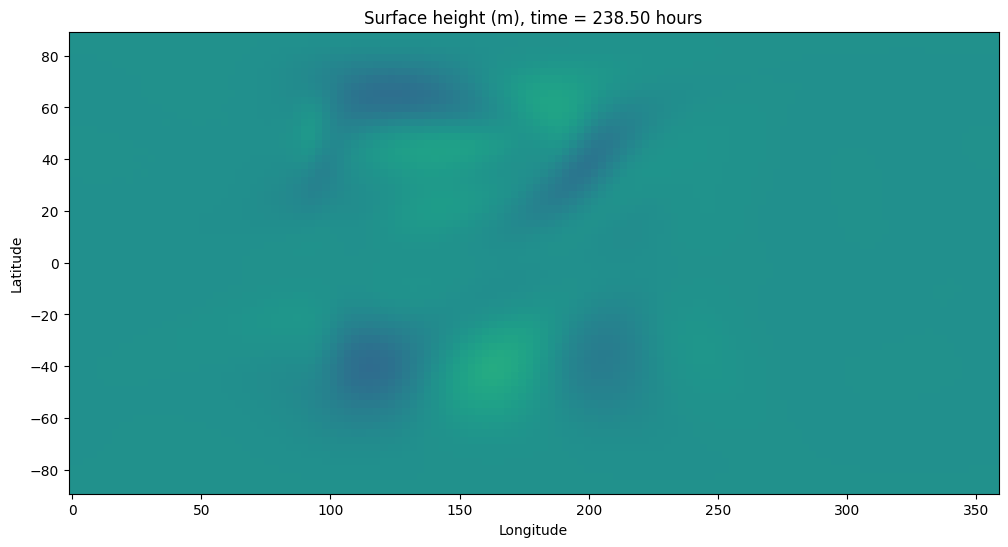

In [5]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

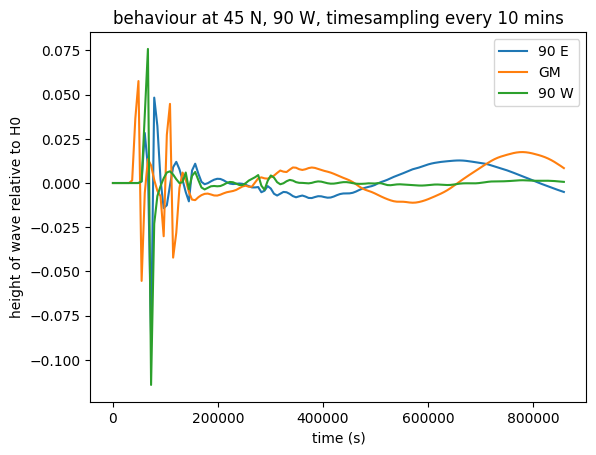

In [9]:
h_save = np.array(h_save)

plt.plot(t_save, h_save[:, 32, 16], label='90 E')
plt.plot(t_save, h_save[:, 64, 16], label= 'GM')
plt.plot(t_save, h_save[:, 96, 16], label= '90 W')
plt.legend()
plt.title('behaviour at 45 N, 90 W, timesampling every 10 mins')
plt.ylabel('height of wave relative to H0')
plt.xlabel('time (s)')
plt.show()

from video, wave remnants seem to drift leftwards, producing the oscilation in 90 e that we dont see in 90w. this differs from predicted theory?

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?